# INTRO TO THE PROJECT

In [1]:
# Download libraries
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-multilearn
!pip install kagglehub
!pip install plotly
!pip install nba_api
!pip install py-stringmatching
!pip install setuptools==58.0.4
!pip install py-stringsimjoin
# !pip install pyspark
# !pip install pyarrow



# Importing libraries and packages

In [2]:

#  git lfs track "*.csv" 
# git lfs track "notebooks/database.db"

import os
import glob
import kagglehub
import sqlite3
import zipfile
import pandas as pd
from io import BytesIO
from functools import reduce
import sqlite3 as sql

# Spark
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark import SparkFiles
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#Data Wrangling

import numpy as np
import pandas as pd

# Linear Models
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

#Trees
from sklearn import tree
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Preprocessing Packages
from sklearn.model_selection import train_test_split

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Model tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Aditonal Data Sources
from nba_api.stats.endpoints import TeamInfoCommon
from nba_api.stats.static import teams

#Record Linking
import py_stringmatching as sm
import py_stringsimjoin as ssj

%matplotlib inline

/Users/fant1c/miniconda3/envs/project-cis-5450/lib/python3.8/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


# Loading Data Sets
- Load NBA teams information
- Load NBA Shots from 2003-2024 seasons
- Load NBA players information

In [3]:
# Path to your zip file
current_dir = os.getcwd()
zip_file_path = current_dir + '/../raw-data/nba-shots.zip'
# list to store dataframes from CSV
csv_dataframes = []
# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Loop through each file in the zip
    for file_name in zip_file.namelist():
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            with zip_file.open(file_name) as file:
                df = pd.read_csv(file)
                csv_dataframes.append(df)  # Store the DataFrame in the dictionary
                print(file_name)

# Now, `csv_dataframes` contains DataFrames for each CSV file
# You can access them by file name, for example:
df = pd.concat(csv_dataframes)
df.head()

NBA_2004_Shots.csv
NBA_2005_Shots.csv
NBA_2006_Shots.csv
NBA_2007_Shots.csv
NBA_2008_Shots.csv
NBA_2009_Shots.csv
NBA_2010_Shots.csv
NBA_2011_Shots.csv
NBA_2012_Shots.csv
NBA_2013_Shots.csv
NBA_2014_Shots.csv
NBA_2015_Shots.csv
NBA_2016_Shots.csv
NBA_2017_Shots.csv
NBA_2018_Shots.csv
NBA_2019_Shots.csv
NBA_2020_Shots.csv
NBA_2021_Shots.csv
NBA_2022_Shots.csv
NBA_2023_Shots.csv
NBA_2024_Shots.csv


SEASON_1 SEASON_2     TEAM_ID               TEAM_NAME  PLAYER_ID  \
0      2004  2003-04  1610612747      Los Angeles Lakers        977   
1      2004  2003-04  1610612757  Portland Trail Blazers        757   
2      2004  2003-04  1610612747      Los Angeles Lakers        977   
3      2004  2003-04  1610612757  Portland Trail Blazers        757   
4      2004  2003-04  1610612757  Portland Trail Blazers        757   

        PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...  \
0       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
1  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
2       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
3  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
4  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   

          BASIC_ZONE         ZONE_NAME ZONE_ABB       ZONE_RANGE LOC_X  LOC_Y  \
0  Above the Break 3  Left Side Center       LC          24+ ft.  20.0  21.35   
1    Restricted Area            Center        C  Less Than 8 ft.  -0.0   5.25   
2          Mid-Range  Left Side Center       LC        16-24 ft.  13.3  24.45   
3          Mid-Range         Left Side        L        16-24 ft.  16.4  13.95   
4          Mid-Range        Right Side        R        16-24 ft. -15.8   7.85   

  SHOT_DISTANCE QUARTER MINS_LEFT SECS_LEFT  
0            25       6         0         0  
1             0       6         0         2  
2            23       6         0         9  
3            18       6         0        31  
4            16       6         0        55  

[5 rows x 26 columns]

In [4]:
nba_teams_file = current_dir + "/../raw-data/nba-teams.csv"
if not os.path.exists(nba_teams_file):
    print("File is not present, we use an NBA API Fetch Call")
    nba_teams = teams.get_teams()
    # Create a dictionary of team IDs
    team_ids_dict = {team['full_name']: team['id'] for team in nba_teams}
    # Create an empty DataFrame to store the data
    df_teams = pd.DataFrame()
    # Loop through the teams and append to the df
    for team_name, team_id in team_ids_dict.items():
        team_info = TeamInfoCommon(team_id=team_id)
        df_team = team_info.get_data_frames()[0]
        df_team['TeamName'] = team_name  # Adding the team name to the DataFrame
        df_teams = pd.concat([df_teams, df_team], ignore_index=True)
    # Print the combined DataFrame
else:
    print("File is present")
    df_teams = pd.read_csv(nba_teams_file)
df_teams

File is present


TEAM_ID SEASON_YEAR      TEAM_CITY      TEAM_NAME TEAM_ABBREVIATION  \
0   1610612737     2024-25        Atlanta          Hawks               ATL   
1   1610612738     2024-25         Boston        Celtics               BOS   
2   1610612739     2024-25      Cleveland      Cavaliers               CLE   
3   1610612740     2024-25    New Orleans       Pelicans               NOP   
4   1610612741     2024-25        Chicago          Bulls               CHI   
5   1610612742     2024-25         Dallas      Mavericks               DAL   
6   1610612743     2024-25         Denver        Nuggets               DEN   
7   1610612744     2024-25   Golden State       Warriors               GSW   
8   1610612745     2024-25        Houston        Rockets               HOU   
9   1610612746     2024-25             LA       Clippers               LAC   
10  1610612747     2024-25    Los Angeles         Lakers               LAL   
11  1610612748     2024-25          Miami           Heat               MIA   
12  1610612749     2024-25      Milwaukee          Bucks               MIL   
13  1610612750     2024-25      Minnesota   Timberwolves               MIN   
14  1610612751     2024-25       Brooklyn           Nets               BKN   
15  1610612752     2024-25       New York         Knicks               NYK   
16  1610612753     2024-25        Orlando          Magic               ORL   
17  1610612754     2024-25        Indiana         Pacers               IND   
18  1610612755     2024-25   Philadelphia          76ers               PHI   
19  1610612756     2024-25        Phoenix           Suns               PHX   
20  1610612757     2024-25       Portland  Trail Blazers               POR   
21  1610612758     2024-25     Sacramento          Kings               SAC   
22  1610612759     2024-25    San Antonio          Spurs               SAS   
23  1610612760     2024-25  Oklahoma City        Thunder               OKC   
24  1610612761     2024-25        Toronto        Raptors               TOR   
25  1610612762     2024-25           Utah           Jazz               UTA   
26  1610612763     2024-25        Memphis      Grizzlies               MEM   
27  1610612764     2024-25     Washington        Wizards               WAS   
28  1610612765     2024-25        Detroit        Pistons               DET   
29  1610612766     2024-25      Charlotte        Hornets               CHA   

   TEAM_CONFERENCE TEAM_DIVISION     TEAM_CODE     TEAM_SLUG   W   L    PCT  \
0             East     Southeast         hawks         hawks   7   8  0.467   
1             East      Atlantic       celtics       celtics  11   3  0.786   
2             East       Central     cavaliers     cavaliers  15   0  1.000   
3             West     Southwest      pelicans      pelicans   4  10  0.286   
4             East       Central         bulls         bulls   6   9  0.400   
5             West     Southwest     mavericks     mavericks   7   7  0.500   
6             West     Northwest       nuggets       nuggets   7   5  0.583   
7             West       Pacific      warriors      warriors  10   3  0.769   
8             West     Southwest       rockets       rockets  10   5  0.667   
9             West       Pacific      clippers      clippers   8   7  0.533   
10            West       Pacific        lakers        lakers   9   4  0.692   
11            East     Southeast          heat          heat   6   7  0.462   
12            East       Central         bucks         bucks   5   9  0.357   
13            West     Northwest  timberwolves  timberwolves   8   6  0.571   
14            East      Atlantic          nets          nets   5   9  0.357   
15            East      Atlantic        knicks        knicks   8   6  0.571   
16            East     Southeast         magic         magic   9   6  0.600   
17            East       Central        pacers        pacers   6   8  0.429   
18            East      Atlantic        sixers        sixers   2  11  0.154   
19      

In [5]:
current_dir = os.getcwd()
dir_path = current_dir + '/../raw-data/'
df_players = pd.read_csv(dir_path + "common_player_info.csv")
df_players.head()

person_id first_name     last_name   display_first_last  \
0      76001       Alaa     Abdelnaby       Alaa Abdelnaby   
1      76003     Kareem  Abdul-Jabbar  Kareem Abdul-Jabbar   
2       1505      Tariq   Abdul-Wahad    Tariq Abdul-Wahad   
3        949    Shareef   Abdur-Rahim  Shareef Abdur-Rahim   
4      76005        Tom     Abernethy        Tom Abernethy   

  display_last_comma_first  display_fi_last          player_slug  \
0          Abdelnaby, Alaa     A. Abdelnaby       alaa-abdelnaby   
1     Abdul-Jabbar, Kareem  K. Abdul-Jabbar  kareem-abdul-jabbar   
2       Abdul-Wahad, Tariq   T. Abdul-Wahad    tariq-abdul-wahad   
3     Abdur-Rahim, Shareef   S. Abdur-Rahim  shareef-abdur-rahim   
4           Abernethy, Tom     T. Abernethy        tom-abernethy   

             birthdate          school country  ...  \
0  1968-06-24 00:00:00            Duke     USA  ...   
1  1947-04-16 00:00:00            UCLA     USA  ...   
2  1974-11-03 00:00:00  San Jose State  France  ...   
3  1976-12-11 00:00:00      California     USA  ...   
4  1954-05-06 00:00:00         Indiana     USA  ...   

                    playercode from_year  to_year  dleague_flag nba_flag  \
0       HISTADD_alaa_abdelnaby    1990.0   1994.0             N        Y   
1  HISTADD_kareem_abdul-jabbar    1969.0   1988.0             N        Y   
2            tariq_abdul-wahad    1997.0   2003.0             N        Y   
3          shareef_abdur-rahim    1996.0   2007.0             N        Y   
4        HISTADD_tom_abernethy    1976.0   1980.0             N        Y   

  games_played_flag draft_year draft_round  draft_number greatest_75_flag  
0                 Y       1990           1            25                N  
1                 Y       1969           1             1                Y  
2                 Y       1997           1            11                N  
3                 Y       1996           1             3                N  
4                 Y       1976           3            43                N  

[5 rows x 33 columns]

# Data Dictionary

**Self-Explanatory**: **TEAM_NAME**, **PLAYER_NAME**, **POSITION_GROUP**, **POSITION**, **HOME_TEAM**, **AWAY_TEAM**

- **SEASON_1** & **SEASON_2**: Season indicator variables  
- **TEAM_ID**: NBA's unique ID variable of that specific team in their API  
- **PLAYER_ID**: NBA's unique ID variable of that specific player in their API  
- **GAME_DATE**: Date of the game (M-D-Y // Month-Date-Year)  
- **GAME_ID**: NBA's unique ID variable of that specific game in their API  
- **EVENT_TYPE**: Character variable denoting a shot outcome (Made Shot // Missed Shot)  
- **SHOT_MADE**: True/False variable denoting a shot outcome (True // False)  
- **ACTION_TYPE**: Description of shot type (layup, dunk, jump shot, etc.)  
- **SHOT_TYPE**: Type of shot (2PT or 3PT)  
- **BASIC_ZONE**: Name of the court zone the shot took place in  
  - Restricted Area, In the Paint (non-RA), Midrange, Left Corner 3, Right Corner 3, Above the Break, Backcourt  
- **ZONE_NAME**: Name of the side of court the shot took place in  
  - left, left side center, center, right side center, right  
- **ZONE_ABB**: Abbreviation of the side of court  
  - (L), (LC), (C), (RC), (R)  
- **ZONE_RANGE**: Distance range of shot by zones  
  - Less than 8 ft., 8-16 ft. 16-24 ft. 24+ ft.  
- **LOC_X**: X coordinate of the shot in the x, y plane of the court (0, 50)  
- **LOC_Y**: Y coordinate of the shot in the x, y plane of the court (0, 50)  
- **SHOT_DISTANCE**: Distance of the shot with respect to the center of the hoop, in feet  
- **QUARTER**: Quarter of the game  
- **MINS_LEFT**: Minutes remaining in the quarter  
- **SECS_LEFT**: Seconds remaining in minute of the quarter  


# DATA Cleaning, Wrangling and Record Linking

In [6]:
df["ACTION_TYPE"].unique()

array(['Jump Shot', 'Driving Layup Shot', 'Dunk Shot',
       'Alley Oop Dunk Shot', 'Fadeaway Jump Shot',
       'Driving Finger Roll Shot', 'Layup Shot', 'Tip Shot',
       'Slam Dunk Shot', 'Running Hook Shot', 'Turnaround Jump Shot',
       'Running Layup Shot', 'Jump Bank Shot', 'Running Jump Shot',
       'Jump Hook Shot', 'Reverse Layup Shot', 'Driving Dunk Shot',
       'Hook Shot', 'Reverse Dunk Shot', 'Running Finger Roll Shot',
       'Turnaround Hook Shot', 'Alley Oop Layup shot',
       'Follow Up Dunk Shot', 'Driving Hook Shot', 'Running Dunk Shot',
       'Finger Roll Shot', 'Hook Bank Shot',
       'Turnaround Finger Roll Shot', 'Running Tip Shot',
       'Turnaround Fadeaway shot', 'Driving Slam Dunk Shot',
       'Step Back Jump shot', 'Pullup Jump shot', 'Running Bank shot',
       'Driving Finger Roll Layup Shot', 'Finger Roll Layup Shot',
       'Pullup Bank shot', 'Putback Dunk Shot', 'Floating Jump shot',
       'Putback Layup Shot', 'Jump Bank Hook Shot',
      

In [7]:
# inspect the Leagues data set
print("Number of duplicate rows: " + str(df.duplicated().sum()))
print("dtypes:")
print(df.dtypes)
print("----------------------------\nLeagues DF describe:")
print(df.describe())
print("----------------------------\nCheck for Null values:")
print(df.isna().sum())
print("----------------------------\nFirst 5 rows of the dataset")
df.head()

Number of duplicate rows: 192
dtypes:
SEASON_1            int64
SEASON_2           object
TEAM_ID             int64
TEAM_NAME          object
PLAYER_ID           int64
PLAYER_NAME        object
POSITION_GROUP     object
POSITION           object
GAME_DATE          object
GAME_ID             int64
HOME_TEAM          object
AWAY_TEAM          object
EVENT_TYPE         object
SHOT_MADE            bool
ACTION_TYPE        object
SHOT_TYPE          object
BASIC_ZONE         object
ZONE_NAME          object
ZONE_ABB           object
ZONE_RANGE         object
LOC_X             float64
LOC_Y             float64
SHOT_DISTANCE       int64
QUARTER             int64
MINS_LEFT           int64
SECS_LEFT           int64
dtype: object
----------------------------
Leagues DF describe:
           SEASON_1       TEAM_ID     PLAYER_ID       GAME_ID         LOC_X  \
count  4.231262e+06  4.231262e+06  4.231262e+06  4.231262e+06  4.231262e+06   
mean   2.014191e+03  1.610613e+09  4.136611e+05  2.131969e+07  9

SEASON_1 SEASON_2     TEAM_ID               TEAM_NAME  PLAYER_ID  \
0      2004  2003-04  1610612747      Los Angeles Lakers        977   
1      2004  2003-04  1610612757  Portland Trail Blazers        757   
2      2004  2003-04  1610612747      Los Angeles Lakers        977   
3      2004  2003-04  1610612757  Portland Trail Blazers        757   
4      2004  2003-04  1610612757  Portland Trail Blazers        757   

        PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...  \
0       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
1  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
2       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
3  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
4  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   

          BASIC_ZONE         ZONE_NAME ZONE_ABB       ZONE_RANGE LOC_X  LOC_Y  \
0  Above the Break 3  Left Side Center       LC          24+ ft.  20.0  21.35   
1    Restricted Area            Center        C  Less Than 8 ft.  -0.0   5.25   
2          Mid-Range  Left Side Center       LC        16-24 ft.  13.3  24.45   
3          Mid-Range         Left Side        L        16-24 ft.  16.4  13.95   
4          Mid-Range        Right Side        R        16-24 ft. -15.8   7.85   

  SHOT_DISTANCE QUARTER MINS_LEFT SECS_LEFT  
0            25       6         0         0  
1             0       6         0         2  
2            23       6         0         9  
3            18       6         0        31  
4            16       6         0        55  

[5 rows x 26 columns]

In [8]:
df_shots_clean = df.drop_duplicates()
df_shots_clean.head()

SEASON_1 SEASON_2     TEAM_ID               TEAM_NAME  PLAYER_ID  \
0      2004  2003-04  1610612747      Los Angeles Lakers        977   
1      2004  2003-04  1610612757  Portland Trail Blazers        757   
2      2004  2003-04  1610612747      Los Angeles Lakers        977   
3      2004  2003-04  1610612757  Portland Trail Blazers        757   
4      2004  2003-04  1610612757  Portland Trail Blazers        757   

        PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...  \
0       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
1  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
2       Kobe Bryant              G       SG  04-14-2004  20301187  ...   
3  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   
4  Damon Stoudamire              G       PG  04-14-2004  20301187  ...   

          BASIC_ZONE         ZONE_NAME ZONE_ABB       ZONE_RANGE LOC_X  LOC_Y  \
0  Above the Break 3  Left Side Center       LC          24+ ft.  20.0  21.35   
1    Restricted Area            Center        C  Less Than 8 ft.  -0.0   5.25   
2          Mid-Range  Left Side Center       LC        16-24 ft.  13.3  24.45   
3          Mid-Range         Left Side        L        16-24 ft.  16.4  13.95   
4          Mid-Range        Right Side        R        16-24 ft. -15.8   7.85   

  SHOT_DISTANCE QUARTER MINS_LEFT SECS_LEFT  
0            25       6         0         0  
1             0       6         0         2  
2            23       6         0         9  
3            18       6         0        31  
4            16       6         0        55  

[5 rows x 26 columns]

In [9]:
df_shots_clean = df_shots_clean[df_shots_clean["ACTION_TYPE"] != "No Shot"]
# Drop NA records
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean = df_shots_clean.dropna()
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean[df_shots_clean["POSITION_GROUP"].isna() | df_shots_clean["POSITION"].isna()]

Number of rows containing NA values:
POSITION_GROUP    7930
POSITION          7930
dtype: int64
Number of rows containing NA values:
Series([], dtype: int64)


Empty DataFrame
Columns: [SEASON_1, SEASON_2, TEAM_ID, TEAM_NAME, PLAYER_ID, PLAYER_NAME, POSITION_GROUP, POSITION, GAME_DATE, GAME_ID, HOME_TEAM, AWAY_TEAM, EVENT_TYPE, SHOT_MADE, ACTION_TYPE, SHOT_TYPE, BASIC_ZONE, ZONE_NAME, ZONE_ABB, ZONE_RANGE, LOC_X, LOC_Y, SHOT_DISTANCE, QUARTER, MINS_LEFT, SECS_LEFT]
Index: []

[0 rows x 26 columns]

# Keep Only current 30 nba teams and get the respective conference for each team

In [10]:
# Keep only current NBA teams
nba_teams = df_shots_clean[df_shots_clean["SEASON_1"] == 2024].TEAM_NAME.unique()
df_shots_clean = df_shots_clean[df_shots_clean["TEAM_NAME"].isin(nba_teams)]
print(sorted(df_shots_clean.TEAM_NAME.unique()) == sorted(df_teams.TeamName))
# merge on team abbreviation 
df_shots_clean = df_shots_clean.merge(df_teams[['TeamName', 'TEAM_CONFERENCE', "TEAM_ABBREVIATION"]],
                                      left_on='TEAM_NAME', right_on='TeamName', how='inner')
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean = df_shots_clean.dropna()
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean.head()

False
Number of rows containing NA values:
Series([], dtype: int64)
Number of rows containing NA values:
Series([], dtype: int64)


SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  PLAYER_NAME  \
0      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
1      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
2      2004  2003-04  1610612747  Los Angeles Lakers       2567   Brian Cook   
3      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
4      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   

  POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...       ZONE_RANGE LOC_X  \
0              G       SG  04-14-2004  20301187  ...          24+ ft.  20.0   
1              G       SG  04-14-2004  20301187  ...        16-24 ft.  13.3   
2              C        C  04-14-2004  20301187  ...  Less Than 8 ft.  -0.0   
3              G       SG  04-14-2004  20301187  ...          24+ ft.  -1.5   
4              G       SG  04-14-2004  20301187  ...        16-24 ft. -14.6   

   LOC_Y  SHOT_DISTANCE QUARTER MINS_LEFT SECS_LEFT            TeamName  \
0  21.35             25       6         0         0  Los Angeles Lakers   
1  24.45             23       6         0         9  Los Angeles Lakers   
2   5.25              0       6         1        12  Los Angeles Lakers   
3  29.95             24       6         1        42  Los Angeles Lakers   
4  16.75             18       6         2        27  Los Angeles Lakers   

  TEAM_CONFERENCE TEAM_ABBREVIATION  
0            West               LAL  
1            West               LAL  
2            West               LAL  
3            West               LAL  
4            West               LAL  

[5 rows x 29 columns]

In [11]:
print(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "East"]["TEAM_NAME"].unique())
print(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "West"]["TEAM_NAME"].unique())
# Check that no team from West appears in East conference and vice versa 
print(bool(set(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "East"]["TEAM_NAME"].unique()).intersection(
    set(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "West"]["TEAM_NAME"].unique()))))

['Atlanta Hawks' 'Boston Celtics' 'Chicago Bulls' 'Miami Heat'
 'Philadelphia 76ers' 'Washington Wizards' 'Indiana Pacers'
 'Orlando Magic' 'Milwaukee Bucks' 'Toronto Raptors' 'New York Knicks'
 'Cleveland Cavaliers' 'Detroit Pistons' 'Brooklyn Nets'
 'Charlotte Hornets']
['Los Angeles Lakers' 'Portland Trail Blazers' 'Denver Nuggets'
 'San Antonio Spurs' 'Utah Jazz' 'Memphis Grizzlies'
 'Minnesota Timberwolves' 'Phoenix Suns' 'Houston Rockets'
 'Sacramento Kings' 'Dallas Mavericks' 'Golden State Warriors'
 'Oklahoma City Thunder' 'New Orleans Pelicans']
False


In [12]:
# drop unnecessary columns
df_clean_players = df_players.drop(
    columns=["draft_round", "draft_number", "first_name", "last_name", "display_last_comma_first", "display_fi_last",
             "player_slug", "jersey", "games_played_current_season_flag", "games_played_flag", "playercode",
             "dleague_flag", "nba_flag", "greatest_75_flag", "team_code"]).drop_duplicates()
df_clean_players.head()

person_id   display_first_last            birthdate          school  \
0      76001       Alaa Abdelnaby  1968-06-24 00:00:00            Duke   
1      76003  Kareem Abdul-Jabbar  1947-04-16 00:00:00            UCLA   
2       1505    Tariq Abdul-Wahad  1974-11-03 00:00:00  San Jose State   
3        949  Shareef Abdur-Rahim  1976-12-11 00:00:00      California   
4      76005        Tom Abernethy  1954-05-06 00:00:00         Indiana   

  country       last_affiliation height  weight  season_exp       position  \
0     USA               Duke/USA   6-10   240.0         5.0        Forward   
1     USA               UCLA/USA    7-2   225.0        20.0         Center   
2  France  San Jose State/France    6-6   235.0         7.0  Forward-Guard   
3     USA         California/USA    6-9   245.0        13.0        Forward   
4     USA            Indiana/USA    6-7   220.0         5.0        Forward   

  rosterstatus     team_id      team_name team_abbreviation     team_city  \
0     Inactive  1610612757  Trail Blazers               POR      Portland   
1     Inactive  1610612747         Lakers               LAL   Los Angeles   
2     Inactive  1610612758          Kings               SAC    Sacramento   
3     Inactive  1610612763      Grizzlies               VAN     Vancouver   
4     Inactive  1610612744       Warriors               GOS  Golden State   

   from_year  to_year draft_year  
0     1990.0   1994.0       1990  
1     1969.0   1988.0       1969  
2     1997.0   2003.0       1997  
3     1996.0   2007.0       1996  
4     1976.0   1980.0       1976

# Link NBA Shots DF and Players DF on Player First Name and Last Name basis via Qgram-Jaccard_join

In [13]:
tok = sm.QgramTokenizer(qval=5, return_set=True)
output_pairs = ssj.jaccard_join(
    df_shots_clean[["PLAYER_ID", "PLAYER_NAME"]].drop_duplicates(subset="PLAYER_ID"),
    df_clean_players,
    'PLAYER_ID',
    'person_id',
    'PLAYER_NAME',
    'display_first_last',
    tok,
    0.7,
    l_out_attrs=['PLAYER_NAME'],
    r_out_attrs=['display_first_last']
)
print("Min sim_score: " + str(output_pairs["_sim_score"].min()))
# since the min score is 1  is no need to do further linking we can just merge
output_pairs

Min sim_score: 1.0


_id  l_PLAYER_ID  r_person_id        l_PLAYER_NAME  \
0        0          949          949  Shareef Abdur-Rahim   
1        1       203518       203518         Alex Abrines   
2        2      1630173      1630173     Precious Achiuwa   
3        3       101165       101165           Alex Acker   
4        4       203112       203112           Quincy Acy   
...    ...          ...          ...                  ...   
1742  1742         1917         1917         Wang Zhi-zhi   
1743  1743      1627757      1627757    Stephen Zimmerman   
1744  1744      1627835      1627835          Paul Zipser   
1745  1745      1627790      1627790           Ante Zizic   
1746  1746      1627826      1627826          Ivica Zubac   

     r_display_first_last  _sim_score  
0     Shareef Abdur-Rahim         1.0  
1            Alex Abrines         1.0  
2        Precious Achiuwa         1.0  
3              Alex Acker         1.0  
4              Quincy Acy         1.0  
...                   ...         ...  
1742         Wang Zhi-zhi         1.0  
1743    Stephen Zimmerman         1.0  
1744          Paul Zipser         1.0  
1745           Ante Zizic         1.0  
1746          Ivica Zubac         1.0  

[1747 rows x 6 columns]

In [14]:
# perform the merge for linked players records
df_clean_players = df_clean_players[df_clean_players["display_first_last"].isin(output_pairs["r_display_first_last"])]
df_clean_players = df_clean_players.merge(right=output_pairs[["l_PLAYER_ID", "r_person_id"]], left_on="person_id",
                                          right_on="r_person_id", how="inner").drop(
    columns=["r_person_id", "person_id"]).rename(
    columns={"l_PLAYER_ID": "PLAYER_ID", "team_abbreviation": "TEAM_ABBREVIATION", "team_name": "TeamName",
             "team_city": "TEAM_CITY"}).reset_index(drop=True)
# convert birthdate to age
today = pd.to_datetime("2024")
df_clean_players["birthdate"] = pd.to_datetime(df_clean_players["birthdate"])
df_clean_players["age"] = (today - df_clean_players["birthdate"]).dt.days // 365
df_clean_players

display_first_last  birthdate         school  country  \
0     Shareef Abdur-Rahim 1976-12-11     California      USA   
1            Alex Abrines 1993-08-01   FC Barcelona    Spain   
2        Precious Achiuwa 1999-09-19        Memphis  Nigeria   
3              Alex Acker 1983-01-21     Pepperdine      USA   
4              Quincy Acy 1990-10-06         Baylor      USA   
...                   ...        ...            ...      ...   
1742         Wang Zhi-zhi 1977-07-08           Bayi    China   
1743    Stephen Zimmerman 1996-09-09           UNLV      USA   
1744          Paul Zipser 1994-02-18  Bayern Munich  Germany   
1745           Ante Zizic 1997-01-04    Darussafaka  Croatia   
1746          Ivica Zubac 1997-03-18    Mega Basket  Croatia   

           last_affiliation height  weight  season_exp position rosterstatus  \
0            California/USA    6-9   245.0        13.0  Forward     Inactive   
1        FC Barcelona/Spain    6-6   200.0         3.0    Guard     Inactive   
2           Memphis/Nigeria    6-8   225.0         3.0  Forward       Active   
3            Pepperdine/USA    6-5   185.0         3.0    Guard     Inactive   
4                Baylor/USA    6-7   240.0         7.0  Forward     Inactive   
...                     ...    ...     ...         ...      ...          ...   
1742             Bayi/China    7-1   284.0         6.0   Center     Inactive   
1743               UNLV/USA    7-0   240.0         2.0   Center     Inactive   
1744  Bayern Munich/Germany    6-8   226.0         2.0  Forward     Inactive   
1745    Darussafaka/Croatia   6-10   266.0         4.0   Center     Inactive   
1746    Mega Basket/Croatia    7-0   240.0         7.0   Center       Active   

         team_id   TeamName TEAM_ABBREVIATION    TEAM_CITY  from_year  \
0     1610612763  Grizzlies               VAN    Vancouver     1996.0   
1              0        NaN               NaN          NaN     2016.0   
2     1610612761    Raptors               TOR      Toronto     2020.0   
3     1610612746   Clippers               LAC  Los Angeles     2005.0   
4              0        NaN               NaN          NaN     2012.0   
...          ...        ...               ...          ...        ...   
1742           0        NaN               NaN          NaN     2000.0   
1743  1610612753      Magic               ORL      Orlando     2016.0   
1744  1610612741      Bulls               CHI      Chicago     2016.0   
1745  1610612739  Cavaliers               CLE    Cleveland     2017.0   
1746  1610612746   Clippers               LAC           LA     2016.0   

      to_year draft_year  PLAYER_ID  age  
0      2007.0       1996        949   47  
1      2018.0       2013     203518   30  
2      2023.0       2020    1630173   24  
3      2008.0       2005     101165   40  
4      2018.0       2012     203112   33  
...       ...        ...        ...  ...  
1742   2004.0       1999       1917   46  
1743   2016.0       2016    1627757   27  
1744   2017.0       2016    1627835   29  
1745   2019.0       2016    1627790   27  
1746   2023.0       2016    1627826   26  

[1747 rows x 19 columns]

# Fill records where players with NA values for team they play

In [15]:
df_na_players = df_clean_players[df_clean_players["TeamName"].isna()].reset_index(drop=True)
print(len(df_na_players[df_na_players["rosterstatus"] == "Active"]))
# since we have 0 active players with NA values, then we link the latest team from nba shots df to an inactive players
df_na_players = pd.merge(left=df_na_players, right=df_shots_clean[["PLAYER_ID", "TeamName", "GAME_DATE"]].sort_values(
    by="GAME_DATE").drop_duplicates(subset=["PLAYER_ID"], keep="last"), on="PLAYER_ID", how="left").drop(
    columns=["TeamName_x"]).rename(columns={"TeamName_y": "TeamName"}).reset_index(drop=True)
df_na_players = df_na_players.merge(df_teams[["TeamName", "TEAM_ABBREVIATION", "TEAM_CITY"]], on="TeamName",
                                    how="inner").drop(
    columns=["TEAM_ABBREVIATION_x", "TEAM_CITY_x", "GAME_DATE"]).rename(
    columns={"TEAM_ABBREVIATION_y": "TEAM_ABBREVIATION", "TEAM_CITY_y": "TEAM_CITY"}).reset_index(drop=True)
df_na_players

0


display_first_last  birthdate              school  \
0          Alex Abrines 1993-08-01        FC Barcelona   
1      Antonio Anderson 1985-06-05             Memphis   
2           Moses Brown 1999-10-13                UCLA   
3         Deonte Burton 1994-01-31          Iowa State   
4           Tyler Davis 1997-05-22           Texas A&M   
..                  ...        ...                 ...   
478  Miroslav Raduljica 1988-01-05         Efes Pilsen   
479     Mirza Teletovic 1985-09-17            Baskonia   
480       Rashad Vaughn 1996-08-16                UNLV   
481         D.J. Wilson 1996-02-19            Michigan   
482        Nate Wolters 1991-05-15  South Dakota State   

                    country                 last_affiliation height  weight  \
0                     Spain               FC Barcelona/Spain    6-6   200.0   
1                       USA                      Memphis/USA    6-6   215.0   
2                       USA                         UCLA/USA    7-2   245.0   
3                       USA                   Iowa State/USA    6-4   240.0   
4                       USA                    Texas A&M/USA   6-10   266.0   
..                      ...                              ...    ...     ...   
478                  Serbia               Efes Pilsen/Serbia    7-0   250.0   
479  Bosnia and Herzegovina  Baskonia/Bosnia and Herzegovina    6-9   242.0   
480                     USA                         UNLV/USA    6-6   202.0   
481                     USA                     Michigan/USA   6-10   231.0   
482                     USA           South Dakota State/USA    6-4   190.0   

     season_exp       position rosterstatus  team_id  from_year  to_year  \
0           3.0          Guard     Inactive        0     2016.0   2018.0   
1           2.0          Guard     Inactive        0     2009.0   2009.0   
2           4.0         Center     Inactive        0     2019.0   2022.0   
3           3.0  Guard-Forward     Inactive        0     2018.0   2022.0   
4           1.0         Center     Inactive        0     2018.0   2018.0   
..          ...            ...          ...      ...        ...      ...   
478         2.0         Center     Inactive        0     2013.0   2014.0   
479         6.0        Forward     Inactive        0     2012.0   2017.0   
480         3.0          Guard     Inactive        0     2015.0   2017.0   
481         6.0        Forward     Inactive        0     2017.0   2021.0   
482         3.0          Guard     Inactive        0     2013.0   2017.0   

    draft_year  PLAYER_ID  age               TeamName TEAM_ABBREVIATION  \
0         2013     203518   30  Oklahoma City Thunder               OKC   
1    Undrafted     202079   38  Oklahoma City Thunder               OKC   
2    Undrafted    1629650   24  Oklahoma City Thunder               OKC   
3    Undrafted    1629126   29  Oklahoma City Thunder               OKC   
4    Undrafted    1629093   26  Oklahoma City Thunder               OKC   
..         ...        ...  ...                    ...               ...   
478  Undrafted     203545   36        Milwaukee Bucks               MIL   
479  Undrafted     203141   38        Milwaukee Bucks               MIL   
480       2015    1626173   27        Milwaukee Bucks               MIL   
481       2017    1628391   27        Milwaukee Bucks               MIL   
482       2013     203489   32        Milwaukee Bucks               MIL   

         TEAM_CITY  
0    Oklahoma City  
1    Oklahoma City  
2    Oklahoma City  
3    Oklahoma City  
4    Oklahoma City  
..             ...  
478      Milwaukee  
479      Milwaukee  
480      Milwaukee  
481      Milwaukee  
482      Milwaukee  

[483 rows x 19 columns]

In [16]:
df_clean_players = df_clean_players.dropna(subset=["TeamName", "TEAM_ABBREVIATION", "TEAM_CITY"])
df_clean_players = pd.concat([df_clean_players, df_na_players], ignore_index=True).dropna()
df_clean_players

display_first_last  birthdate              school  \
0     Shareef Abdur-Rahim 1976-12-11          California   
1        Precious Achiuwa 1999-09-19             Memphis   
2              Alex Acker 1983-01-21          Pepperdine   
3            Jordan Adams 1994-07-08                UCLA   
4            Steven Adams 1993-07-20          Pittsburgh   
...                   ...        ...                 ...   
1742   Miroslav Raduljica 1988-01-05         Efes Pilsen   
1743      Mirza Teletovic 1985-09-17            Baskonia   
1744        Rashad Vaughn 1996-08-16                UNLV   
1745          D.J. Wilson 1996-02-19            Michigan   
1746         Nate Wolters 1991-05-15  South Dakota State   

                     country                 last_affiliation height  weight  \
0                        USA                   California/USA    6-9   245.0   
1                    Nigeria                  Memphis/Nigeria    6-8   225.0   
2                        USA                   Pepperdine/USA    6-5   185.0   
3                        USA                         UCLA/USA    6-5   209.0   
4                New Zealand           Pittsburgh/New Zealand   6-11   265.0   
...                      ...                              ...    ...     ...   
1742                  Serbia               Efes Pilsen/Serbia    7-0   250.0   
1743  Bosnia and Herzegovina  Baskonia/Bosnia and Herzegovina    6-9   242.0   
1744                     USA                         UNLV/USA    6-6   202.0   
1745                     USA                     Michigan/USA   6-10   231.0   
1746                     USA           South Dakota State/USA    6-4   190.0   

      season_exp position rosterstatus     team_id         TeamName  \
0           13.0  Forward     Inactive  1610612763        Grizzlies   
1            3.0  Forward       Active  1610612761          Raptors   
2            3.0    Guard     Inactive  1610612746         Clippers   
3            3.0    Guard     Inactive  1610612763        Grizzlies   
4           10.0   Center       Active  1610612763        Grizzlies   
...          ...      ...          ...         ...              ...   
1742         2.0   Center     Inactive           0  Milwaukee Bucks   
1743         6.0  Forward     Inactive           0  Milwaukee Bucks   
1744         3.0    Guard     Inactive           0  Milwaukee Bucks   
1745         6.0  Forward     Inactive           0  Milwaukee Bucks   
1746         3.0    Guard     Inactive           0  Milwaukee Bucks   

     TEAM_ABBREVIATION    TEAM_CITY  from_year  to_year draft_year  PLAYER_ID  \
0                  VAN    Vancouver     1996.0   2007.0       1996        949   
1                  TOR      Toronto     2020.0   2023.0       2020    1630173   
2                  LAC  Los Angeles     2005.0   2008.0       2005     101165   
3                  MEM      Memphis     2014.0   2015.0       2014     203919   
4                  MEM      Memphis     2013.0   2023.0       2013     203500   
...                ...          ...        ...      ...        ...        ...   
1742               MIL    Milwaukee     2013.0   2014.0  Undrafted     203545   
1743               MIL    Milwaukee     2012.0   2017.0  Undrafted     203141   
1744               MIL    Milwaukee     2015.0   2017.0       2015    1626173   
1745               MIL    Milwaukee     2017.0   2021.0       2017    1628391   
1746               MIL    Milwaukee     2013.0   2017.0       2013     203489   

      age  
0      47  
1      24  
2      40  
3      29  
4      30  
...   ...  
1742   36  
1743   38  
1744   27  
1745   27  
1746   32  

[1707 rows x 19 columns]

# Convert Active-Inactive variable to boolean 1/0

In [17]:
df_clean_players["rosterstatus"] = df_clean_players["rosterstatus"].map(
    lambda record: 1 if record == "Active" else (0 if record == "Inactive" else None))
df_active_players = df_clean_players[df_clean_players["rosterstatus"] == 1]
df_active_players


display_first_last  birthdate           school      country  \
1      Precious Achiuwa 1999-09-19          Memphis      Nigeria   
4          Steven Adams 1993-07-20       Pittsburgh  New Zealand   
5           Bam Adebayo 1997-07-18         Kentucky          USA   
8          Ochai Agbaji 2000-04-20           Kansas          USA   
13         Santi Aldama 2001-01-10  Loyola-Maryland        Spain   
...                 ...        ...              ...          ...   
1256     Thaddeus Young 1988-06-21     Georgia Tech          USA   
1257         Trae Young 1998-09-19         Oklahoma          USA   
1258     Omer Yurtseven 1998-06-19       Georgetown       Turkey   
1259        Cody Zeller 1992-10-05          Indiana          USA   
1263        Ivica Zubac 1997-03-18      Mega Basket      Croatia   

            last_affiliation height  weight  season_exp        position  \
1            Memphis/Nigeria    6-8   225.0         3.0         Forward   
4     Pittsburgh/New Zealand   6-11   265.0        10.0          Center   
5               Kentucky/USA    6-9   255.0         6.0  Center-Forward   
8                 Kansas/USA    6-5   215.0         1.0           Guard   
13     Loyola-Maryland/Spain    7-0   215.0         2.0  Forward-Center   
...                      ...    ...     ...         ...             ...   
1256        Georgia Tech/USA    6-8   235.0        16.0         Forward   
1257            Oklahoma/USA    6-1   164.0         5.0           Guard   
1258       Georgetown/Turkey   6-11   275.0         2.0          Center   
1259             Indiana/USA   6-11   240.0        10.0  Forward-Center   
1263     Mega Basket/Croatia    7-0   240.0         7.0          Center   

      rosterstatus     team_id   TeamName TEAM_ABBREVIATION TEAM_CITY  \
1                1  1610612761    Raptors               TOR   Toronto   
4                1  1610612763  Grizzlies               MEM   Memphis   
5                1  1610612748       Heat               MIA     Miami   
8                1  1610612762       Jazz               UTA      Utah   
13               1  1610612763  Grizzlies               MEM   Memphis   
...            ...         ...        ...               ...       ...   
1256             1  1610612761    Raptors               TOR   Toronto   
1257             1  1610612737      Hawks               ATL   Atlanta   
1258             1  1610612748       Heat               MIA     Miami   
1259             1  1610612748       Heat               MIA     Miami   
1263             1  1610612746   Clippers               LAC        LA   

      from_year  to_year draft_year  PLAYER_ID  age  
1        2020.0   2023.0       2020    1630173   24  
4        2013.0   2023.0       2013     203500   30  
5        2017.0   2023.0       2017    1628389   26  
8        2022.0   2023.0       2022    1630534   23  
13       2021.0   2023.0       2021    1630583   22  
...         ...      ...        ...        ...  ...  
1256     2007.0   2023.0       2007     201152   35  
1257     2018.0   2023.0       2018    1629027   25  
1258     2020.0   2023.0  Undrafted    1630209   25  
1259     2013.0   2023.0       2013     203469   31  
1263     2016.0   2023.0       2016    1627826   26  

[420 rows x 19 columns]

In [18]:
# update the shots df to have active/inactive variable for players
df_shots_clean = pd.merge(left=df_shots_clean, right=df_clean_players[["rosterstatus", "PLAYER_ID"]], on="PLAYER_ID")
df_shots_clean = df_shots_clean.drop(columns=["TeamName"])
# make a variable is_home or not whether team played was home or away team
df_shots_clean.head()

SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  PLAYER_NAME  \
0      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
1      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
2      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
3      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
4      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   

  POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...       ZONE_RANGE LOC_X  \
0              G       SG  04-14-2004  20301187  ...          24+ ft.  20.0   
1              G       SG  04-14-2004  20301187  ...        16-24 ft.  13.3   
2              G       SG  04-14-2004  20301187  ...          24+ ft.  -1.5   
3              G       SG  04-14-2004  20301187  ...        16-24 ft. -14.6   
4              G       SG  04-14-2004  20301187  ...  Less Than 8 ft.  -0.0   

   LOC_Y  SHOT_DISTANCE QUARTER MINS_LEFT SECS_LEFT TEAM_CONFERENCE  \
0  21.35             25       6         0         0            West   
1  24.45             23       6         0         9            West   
2  29.95             24       6         1        42            West   
3  16.75             18       6         2        27            West   
4   5.25              0       6         3        31            West   

  TEAM_ABBREVIATION rosterstatus  
0               LAL            0  
1               LAL            0  
2               LAL            0  
3               LAL            0  
4               LAL            0  

[5 rows x 29 columns]

In [19]:
print(df_shots_clean["SHOT_TYPE"].unique())
# convert SHOT_TYPE to have boolean 1/0 variable for 3PT and 2PT shots respectively
df_shots_clean["SHOT_TYPE"] = df_shots_clean["SHOT_TYPE"].map(lambda x: 1 if x == "3PT Field Goal" else 0)
df_shots_clean = df_shots_clean.rename(columns={"SHOT_TYPE": "IS_3PT"})
# make a variable is_home or not whether team played was home or away team
df_shots_clean["is_home"] = (df_shots_clean["HOME_TEAM"] == df_shots_clean["TEAM_ABBREVIATION"]).astype(int)
df_shots_clean.head()

['3PT Field Goal' '2PT Field Goal']


SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  PLAYER_NAME  \
0      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
1      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
2      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
3      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
4      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   

  POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ... LOC_X  LOC_Y  \
0              G       SG  04-14-2004  20301187  ...  20.0  21.35   
1              G       SG  04-14-2004  20301187  ...  13.3  24.45   
2              G       SG  04-14-2004  20301187  ...  -1.5  29.95   
3              G       SG  04-14-2004  20301187  ... -14.6  16.75   
4              G       SG  04-14-2004  20301187  ...  -0.0   5.25   

  SHOT_DISTANCE  QUARTER MINS_LEFT  SECS_LEFT TEAM_CONFERENCE  \
0            25        6         0          0            West   
1            23        6         0          9            West   
2            24        6         1         42            West   
3            18        6         2         27            West   
4             0        6         3         31            West   

  TEAM_ABBREVIATION rosterstatus is_home  
0               LAL            0       0  
1               LAL            0       0  
2               LAL            0       0  
3               LAL            0       0  
4               LAL            0       0  

[5 rows x 30 columns]

In [20]:
# we have at least 1.3m records of shots for currently active players
df_shots_clean[df_shots_clean["rosterstatus"] == 1]

SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  \
203323       2015  2014-15  1610612747  Los Angeles Lakers     203903   
203324       2015  2014-15  1610612747  Los Angeles Lakers     203903   
203325       2015  2014-15  1610612747  Los Angeles Lakers     203903   
203326       2015  2014-15  1610612747  Los Angeles Lakers     203903   
203327       2015  2014-15  1610612747  Los Angeles Lakers     203903   
...           ...      ...         ...                 ...        ...   
3316076      2024  2023-24  1610612766   Charlotte Hornets    1631109   
3316077      2024  2023-24  1610612766   Charlotte Hornets    1631109   
3316078      2024  2023-24  1610612766   Charlotte Hornets    1631109   
3316079      2024  2023-24  1610612766   Charlotte Hornets    1631109   
3316080      2024  2023-24  1610612766   Charlotte Hornets    1631109   

             PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ...  \
203323   Jordan Clarkson              G       PG  04-13-2015  21401211  ...   
203324   Jordan Clarkson              G       PG  04-13-2015  21401211  ...   
203325   Jordan Clarkson              G       PG  04-13-2015  21401211  ...   
203326   Jordan Clarkson              G       PG  04-13-2015  21401211  ...   
203327   Jordan Clarkson              G       PG  04-13-2015  21401211  ...   
...                  ...            ...      ...         ...       ...  ...   
3316076    Mark Williams              C        C  12-02-2023  22300281  ...   
3316077    Mark Williams              C        C  12-08-2023  22301216  ...   
3316078    Mark Williams              C        C  12-08-2023  22301216  ...   
3316079    Mark Williams              C        C  12-08-2023  22301216  ...   
3316080    Mark Williams              C        C  12-08-2023  22301216  ...   

        LOC_X  LOC_Y SHOT_DISTANCE  QUARTER MINS_LEFT  SECS_LEFT  \
203323   -0.2  32.05            26        4         1         17   
203324   -1.4   8.95             3        4         7         17   
203325   -3.1  30.75            25        4         9         30   
203326  -14.0  19.05            19        4         9         58   
203327   -7.5   9.45             8        3         0          1   
...       ...    ...           ...      ...       ...        ...   
3316076   1.0   6.25             1        4         5         41   
3316077  -2.7  14.15             9        1         9         10   
3316078  -1.0   5.55             1        1         4         45   
3316079  -1.0   9.85             4        3         9         51   
3316080  -1.7   6.55             2        3         4         18   

        TEAM_CONFERENCE TEAM_ABBREVIATION rosterstatus is_home  
203323             West               LAL            1       0  
203324             West               LAL            1       0  
203325             West               LAL            1       0  
203326             West               LAL            1       0  
203327             West               LAL            1       0  
...                 ...               ...          ...     ...  
3316076            East               CHA            1       1  
3316077            East               CHA            1       1  
3316078            East               CHA            1       1  
3316079            East               CHA            1       1  
3316080            East               CHA            1       1  

[1378606 rows x 30 columns]

In [21]:
conn = sql.connect("database.db")
df_shots_clean.to_sql("nba", conn, if_exists="replace", index=False)

3316081

# Exploratory Data Analysis (EDA)
- Jump Shot accuracy by Zone (2pt and 3pt)
- Accuracy by action type (done)
- Most efficient players + shot distribution heat map
- Home vs. Performance for teams
- Time trend in accuracy, points,  action type, etc

# Accuracy by action type

In [22]:
action_types_p = df_shots_clean.ACTION_TYPE.unique()
action_types_sql = pd.read_sql("SELECT DISTINCT ACTION_TYPE from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(action_types_p) == len(action_types_sql)))
action_types_p

Pandas and SQL versions are identical: True


array(['Jump Shot', 'Fadeaway Jump Shot', 'Driving Finger Roll Shot',
       'Driving Layup Shot', 'Running Hook Shot', 'Dunk Shot',
       'Running Dunk Shot', 'Layup Shot', 'Running Layup Shot',
       'Slam Dunk Shot', 'Reverse Layup Shot', 'Finger Roll Shot',
       'Running Jump Shot', 'Turnaround Jump Shot', 'Reverse Dunk Shot',
       'Hook Shot', 'Jump Bank Shot', 'Tip Shot', 'Driving Dunk Shot',
       'Jump Hook Shot', 'Turnaround Finger Roll Shot',
       'Alley Oop Layup shot', 'Follow Up Dunk Shot',
       'Alley Oop Dunk Shot', 'Running Finger Roll Shot',
       'Turnaround Hook Shot', 'Driving Hook Shot', 'Hook Bank Shot',
       'Running Tip Shot', 'Driving Finger Roll Layup Shot',
       'Turnaround Fadeaway shot', 'Finger Roll Layup Shot',
       'Pullup Jump shot', 'Putback Dunk Shot',
       'Driving Reverse Layup Shot', 'Driving Slam Dunk Shot',
       'Turnaround Bank shot', 'Step Back Jump shot',
       'Putback Layup Shot', 'Floating Jump shot', 'Driving Jump sh

In [23]:
query = '''
SELECT ACTION_TYPE, COUNT(*) AS count
FROM nba
GROUP BY ACTION_TYPE
ORDER BY count DESC
'''
top_action_types_df = pd.read_sql(query, conn)
# top_action_types_df = df_shots_clean.groupby("ACTION_TYPE").agg(count=("ACTION_TYPE", "count")).sort_values(by="count",  ascending=False).reset_index()
top_action_types_df = top_action_types_df[
    top_action_types_df["count"] >= top_action_types_df["count"].quantile(0.75)].reset_index(drop=True)
action_types_75_p = df_shots_clean[df_shots_clean["ACTION_TYPE"].isin(top_action_types_df["ACTION_TYPE"])][
    ["ACTION_TYPE", "SHOT_MADE", "SHOT_DISTANCE"]]
action_types_75_p = action_types_75_p.groupby("ACTION_TYPE").agg(accuracy=("SHOT_MADE", "mean"),
                                                                 avg_distance=("SHOT_DISTANCE", "mean"),
                                                                 count=("SHOT_MADE", "count")).reset_index()
action_types_75_p

ACTION_TYPE  accuracy  avg_distance    count
0               Cutting Layup Shot  0.719645      1.699506    35455
1   Driving Finger Roll Layup Shot  0.677061      1.891494    37233
2       Driving Floating Jump Shot  0.433311      7.898551    54372
3               Driving Layup Shot  0.594566      1.546183   229502
4                        Dunk Shot  0.873505      0.390242    51773
5               Fadeaway Jump Shot  0.470550     12.985448    50441
6               Floating Jump shot  0.484464      8.320131    47568
7                        Hook Shot  0.450195      5.566439    51220
8                        Jump Shot  0.345800     20.104960  1551613
9                       Layup Shot  0.468603      0.889824   337505
10                Pullup Jump shot  0.455323     19.102095   185699
11              Reverse Layup Shot  0.660183      0.860571    33006
12               Running Jump Shot  0.473558     13.295188    52946
13              Running Layup Shot  0.646916      1.573997    44556
14             Step Back Jump shot  0.429198     20.465449    69984
15                  Tip Layup Shot  0.485857      0.382753    32666
16                        Tip Shot  0.476542      0.470026    35447
17            Turnaround Jump Shot  0.465921     10.491044    56443

In [24]:
# Bubble Chart (Scatter Plot with Bubble Size)
fig = go.Figure()
fig.update_layout(width=1400, height=800, title="NBA Players Action Type Accuracy, Shot Distance and Attempt Count",
                  xaxis=dict(
                      title="Average Distance from the basket",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  yaxis=dict(
                      title="Accuracy (%)",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  )
fig.add_trace(
    go.Scatter(
        x=action_types_75_p["avg_distance"],
        y=action_types_75_p["accuracy"] * 100,
        mode="markers",
        marker=dict(
            size=action_types_75_p["count"],
            sizemode="area",
            sizeref=100,
            color=action_types_75_p["count"],
            colorscale="Viridis",
            showscale=True,
            line_color='rgb(140, 140, 170)',
            colorbar_title='Shots<br>Count',
        ),
        text=action_types_75_p["ACTION_TYPE"],
        hovertemplate=(
                "Action Type: %{text}<br>" +
                "Accuracy: %{y:.2f}<br>" +
                "Average Distance: %{x:.2f}<br>" +
                "Attempt Count: %{marker.size:.0f}"
        ),
        name="Action Types"
    )
)

# Comparison of 2pt vs. 3pt shots over time

In [25]:
query = '''
SELECT TEAM_NAME, SEASON_1 as season, IS_3PT, AVG(SHOT_MADE)*100 as accuracy, TEAM_CONFERENCE as conference
FROM nba
GROUP BY SEASON_1, TEAM_CONFERENCE, TEAM_NAME, IS_3PT
'''
# Comparison of 2pt vs. 3pt shots over time
shot_type_df = pd.read_sql(query, conn)
shot_type_df

TEAM_NAME  season  IS_3PT   accuracy conference
0         Atlanta Hawks    2004       0  45.346833       East
1         Atlanta Hawks    2004       1  33.010563       East
2        Boston Celtics    2004       0  47.235319       East
3        Boston Celtics    2004       1  35.027933       East
4         Chicago Bulls    2004       0  43.242059       East
...                 ...     ...     ...        ...        ...
1143   Sacramento Kings    2024       1  36.730534       West
1144  San Antonio Spurs    2024       0  53.964497       West
1145  San Antonio Spurs    2024       1  34.807256       West
1146          Utah Jazz    2024       0  55.969905       West
1147          Utah Jazz    2024       1  35.510204       West

[1148 rows x 5 columns]

In [26]:
rolling_mean = shot_type_df.copy()
rolling_mean['rolling_mean'] = rolling_mean['accuracy'].transform(
    lambda x: x.rolling(window=3, center=False).mean()
)
rolling_mean = rolling_mean.dropna(subset=['rolling_mean'])
rolling_mean

TEAM_NAME  season  IS_3PT   accuracy conference  rolling_mean
2          Boston Celtics    2004       0  47.235319       East     41.864239
3          Boston Celtics    2004       1  35.027933       East     38.424605
4           Chicago Bulls    2004       0  43.242059       East     41.835104
5           Chicago Bulls    2004       1  34.536505       East     37.602166
6     Cleveland Cavaliers    2004       0  44.842969       East     40.873845
...                   ...     ...     ...        ...        ...           ...
1143     Sacramento Kings    2024       1  36.730534       West     42.359478
1144    San Antonio Spurs    2024       0  53.964497       West     48.845084
1145    San Antonio Spurs    2024       1  34.807256       West     41.834096
1146            Utah Jazz    2024       0  55.969905       West     48.247219
1147            Utah Jazz    2024       1  35.510204       West     42.095788

[1146 rows x 6 columns]

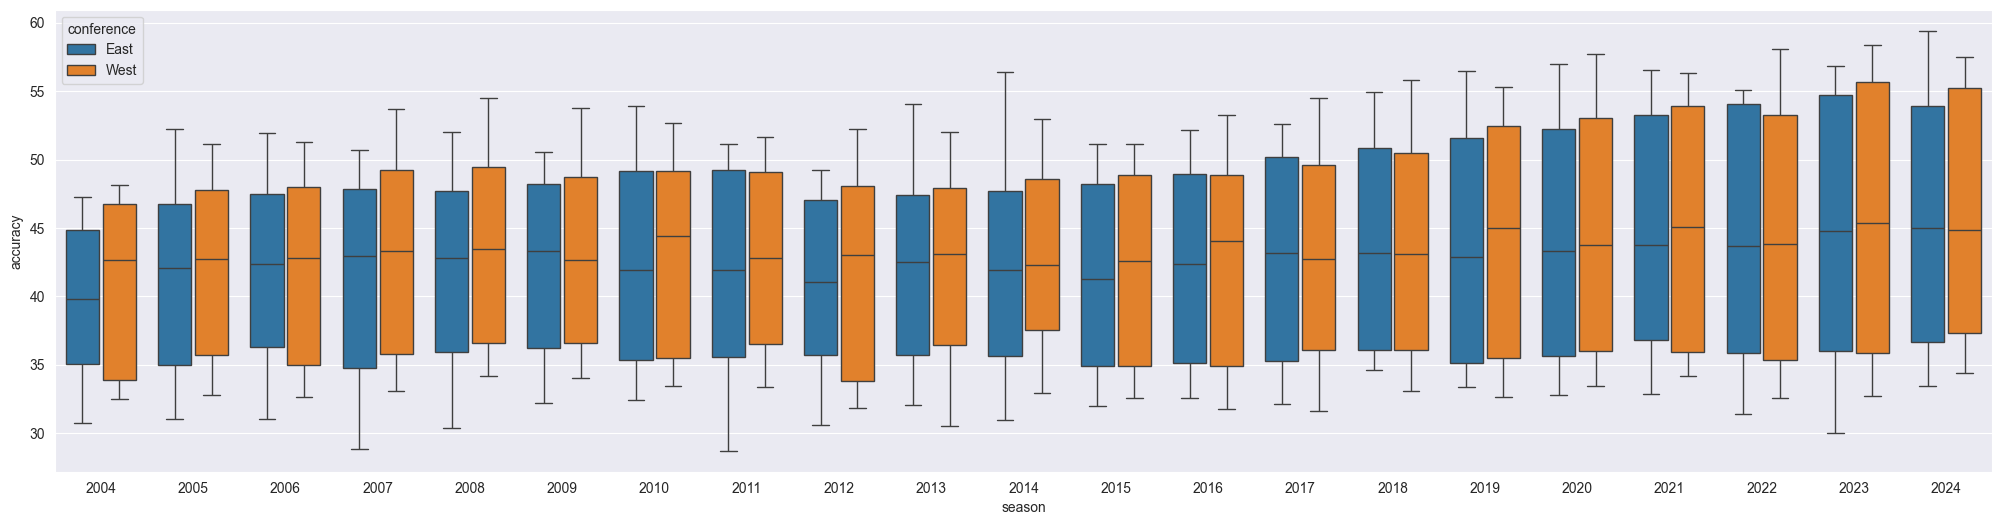

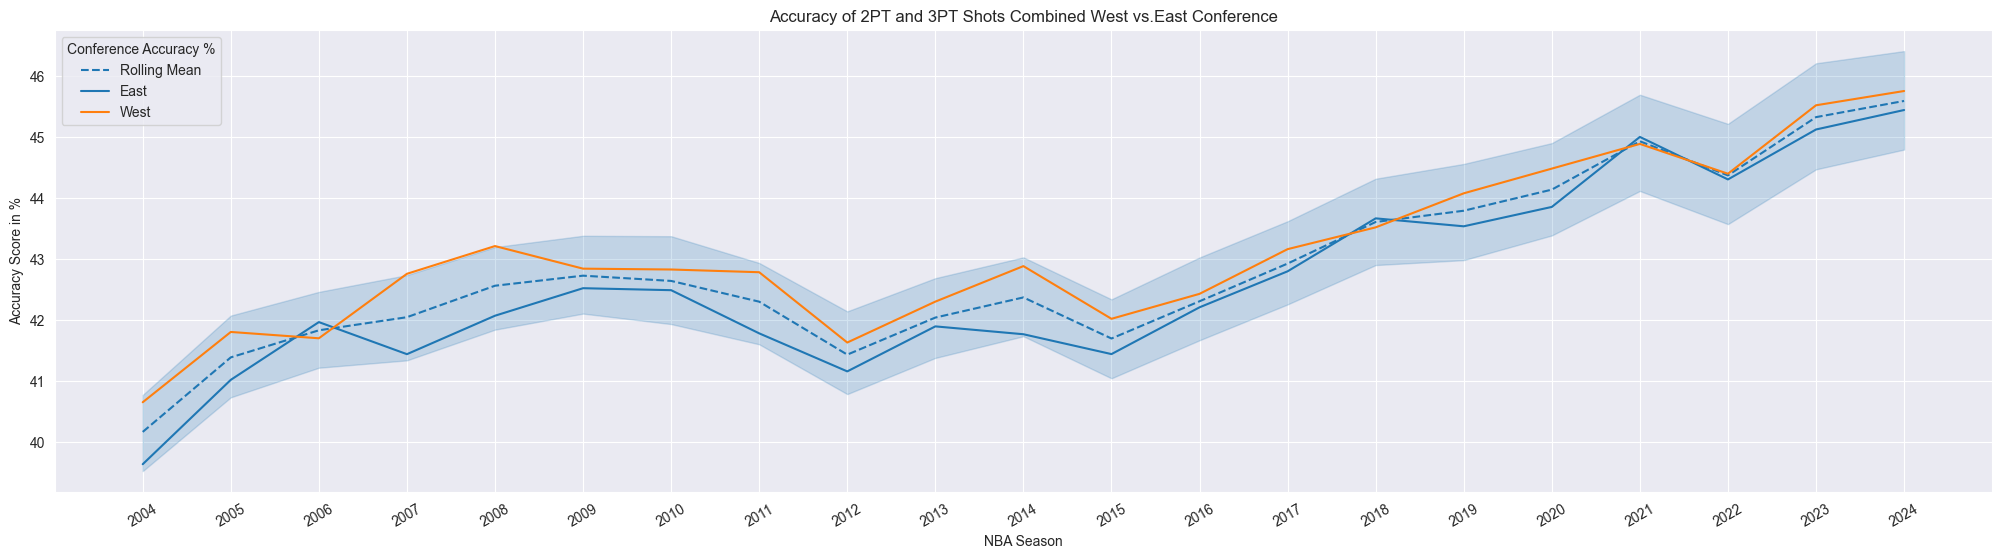

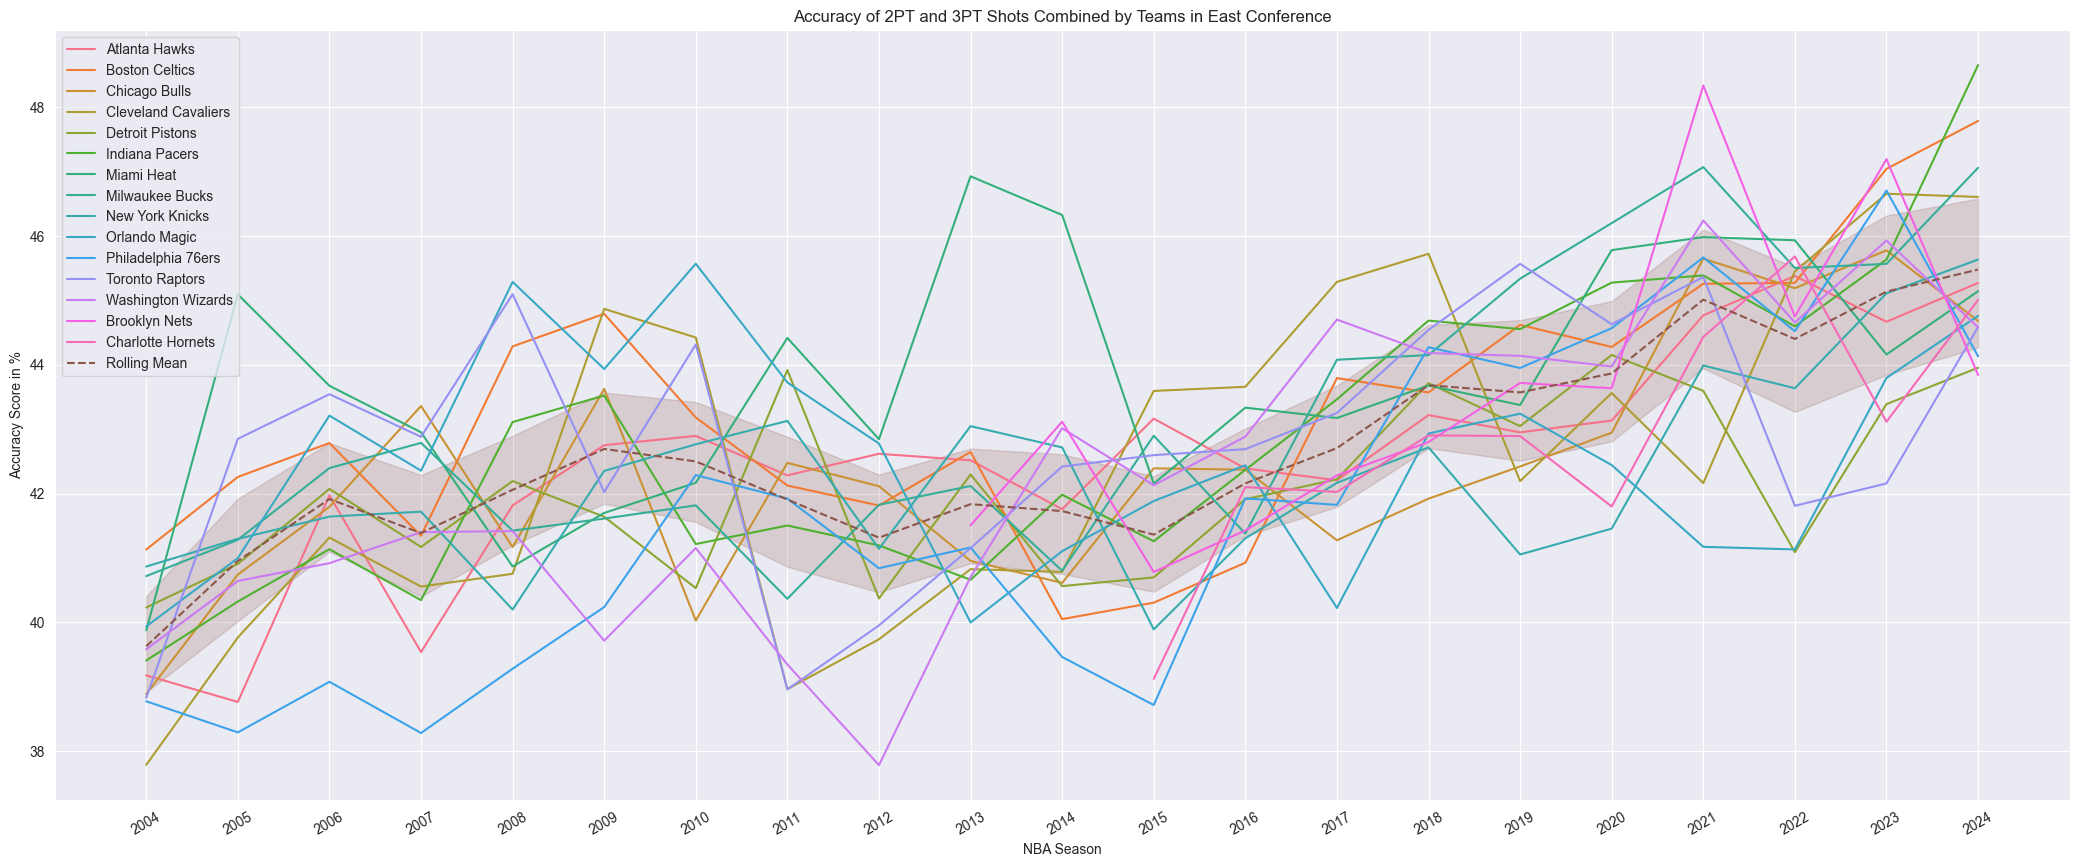

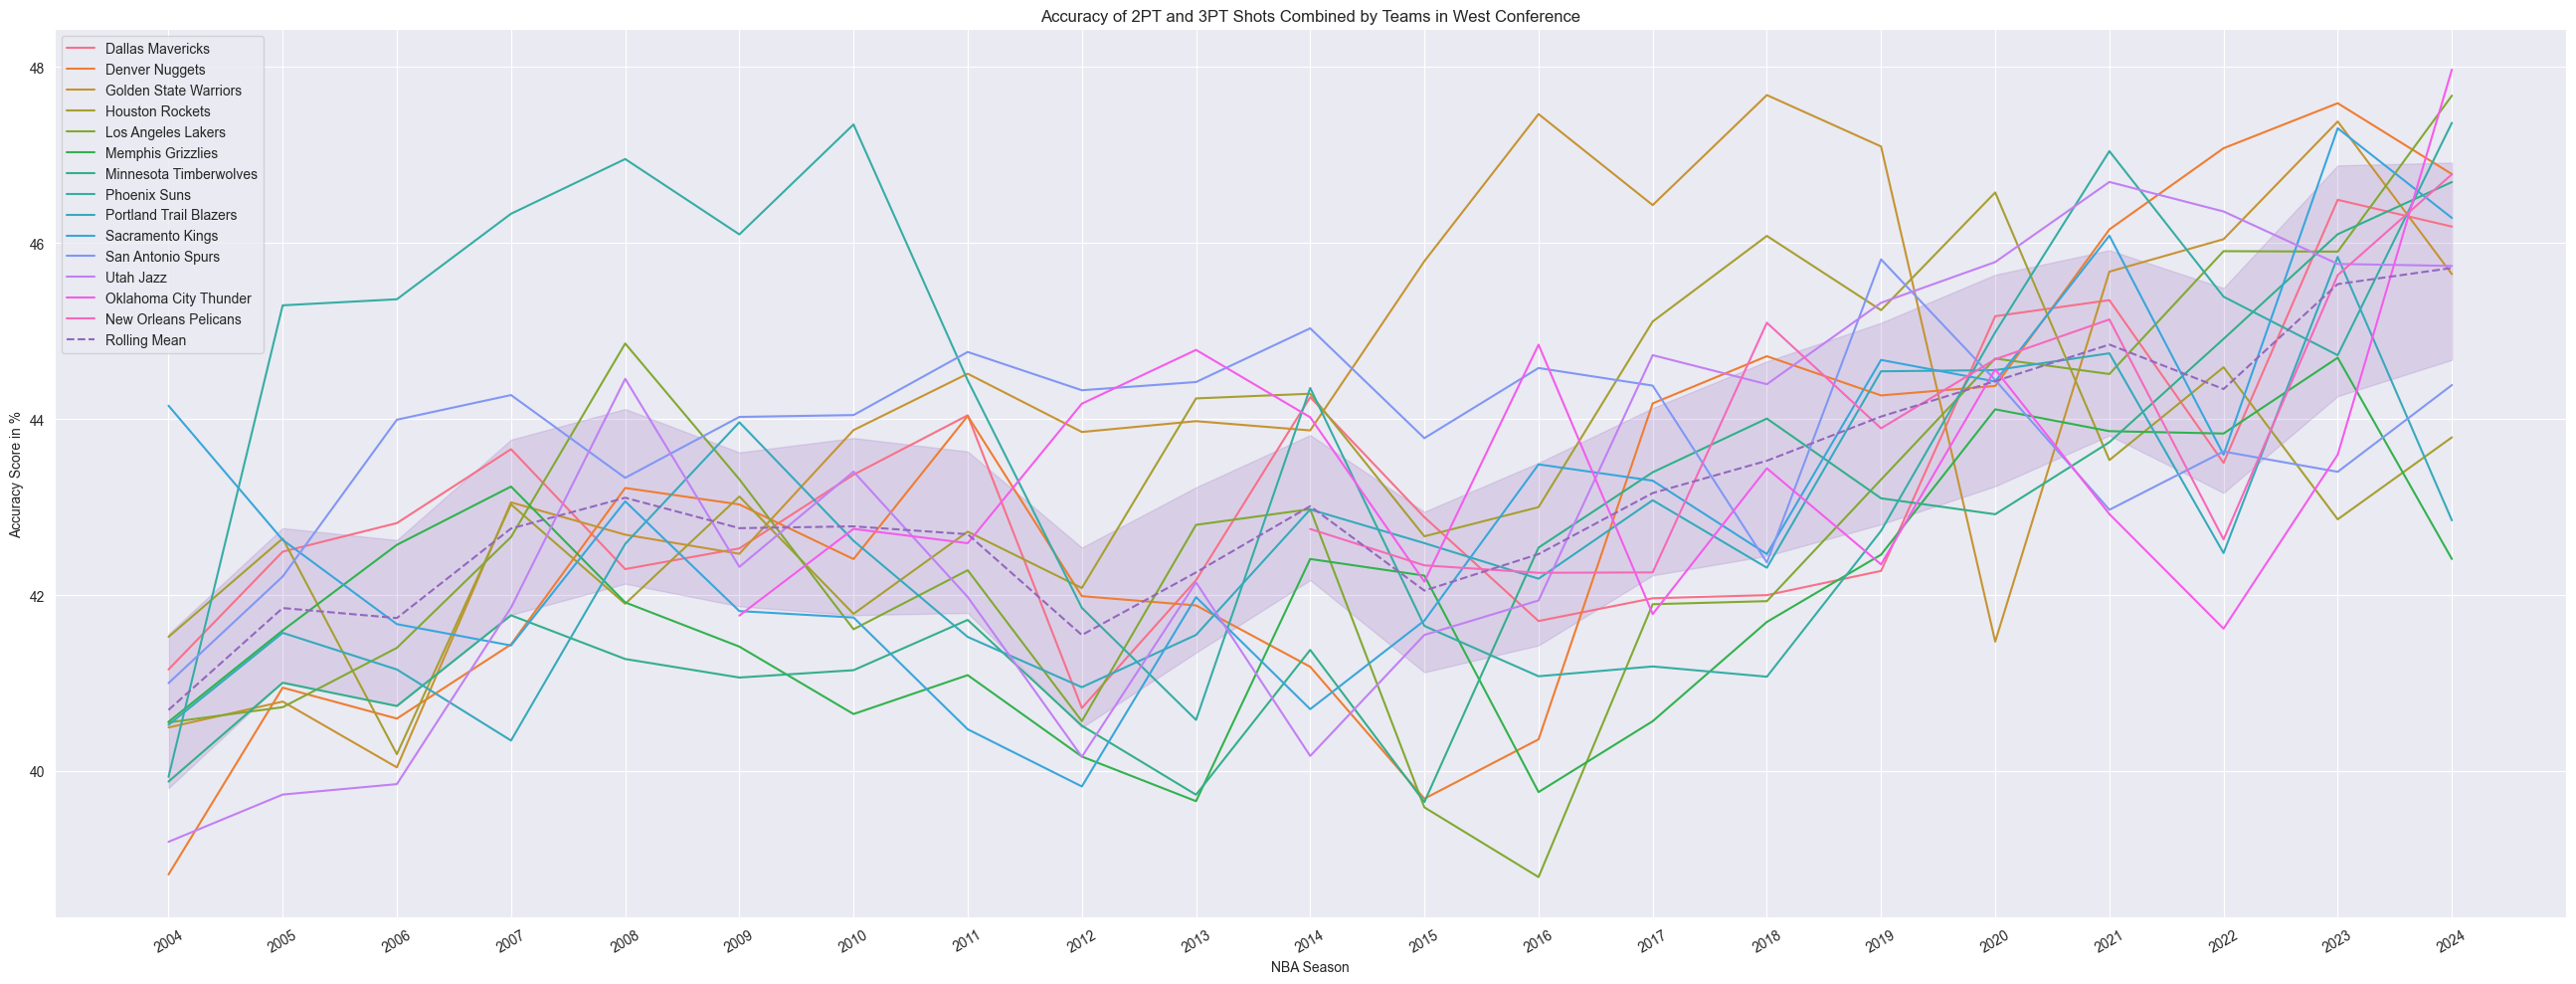

In [27]:
plt.figure(figsize=(25, 6))
#TODO: Perform a ADF test
sns.boxplot(data=shot_type_df, x="season", y="accuracy", hue="conference", gap=.1)

plt.figure(figsize=(25, 6))
# Plot the rolling mean
sns.lineplot(data=rolling_mean, x="season", y="rolling_mean", style=None, linestyle='--',
             markers=False, label="Rolling Mean")
# Plot the League (West and East)
sns.lineplot(data=shot_type_df, x="season", y="accuracy", hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference Accuracy %")
plt.title("Accuracy of 2PT and 3PT Shots Combined West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

# Plot for East Conference
plt.figure(figsize=(26, 10))
sns.lineplot(data=shot_type_df[shot_type_df["conference"] == "East"], x="season", y="accuracy", hue="TEAM_NAME",
             style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT and 3PT Shots Combined by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
# Plot the rolling mean
sns.lineplot(data=rolling_mean[rolling_mean["conference"] == "East"], x="season", y="rolling_mean", style=None,
             linestyle='--',
             markers=False, label="Rolling Mean")
# Plot for West Conference
plt.figure(figsize=(26, 10))
sns.lineplot(data=shot_type_df[shot_type_df["conference"] == "West"], x="season", y="accuracy", hue="TEAM_NAME",
             style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT and 3PT Shots Combined by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
# Plot the rolling mean
sns.lineplot(data=rolling_mean[rolling_mean["conference"] == "West"], x="season", y="rolling_mean", style=None,
             linestyle='--',
             markers=False, label="Rolling Mean")
plt.tight_layout()
plt.show()

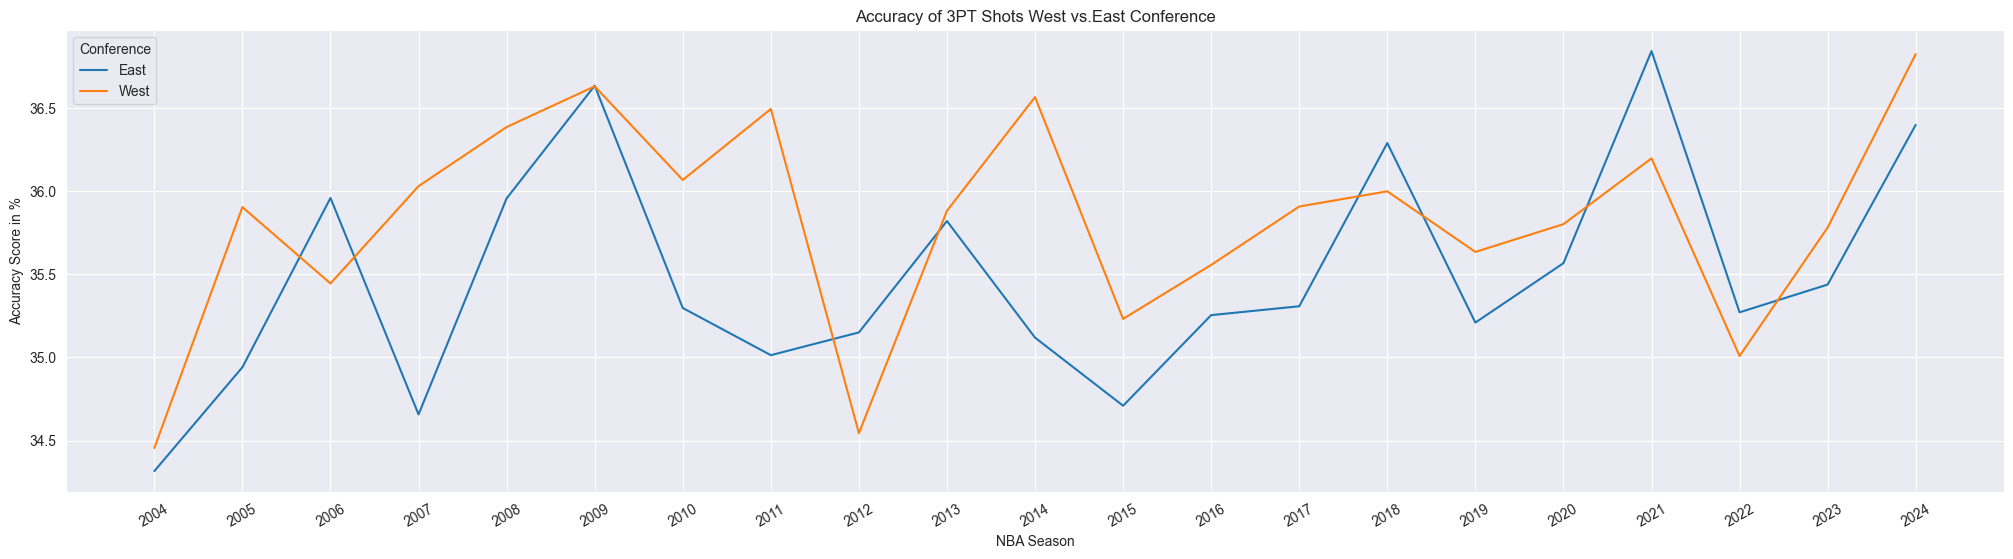

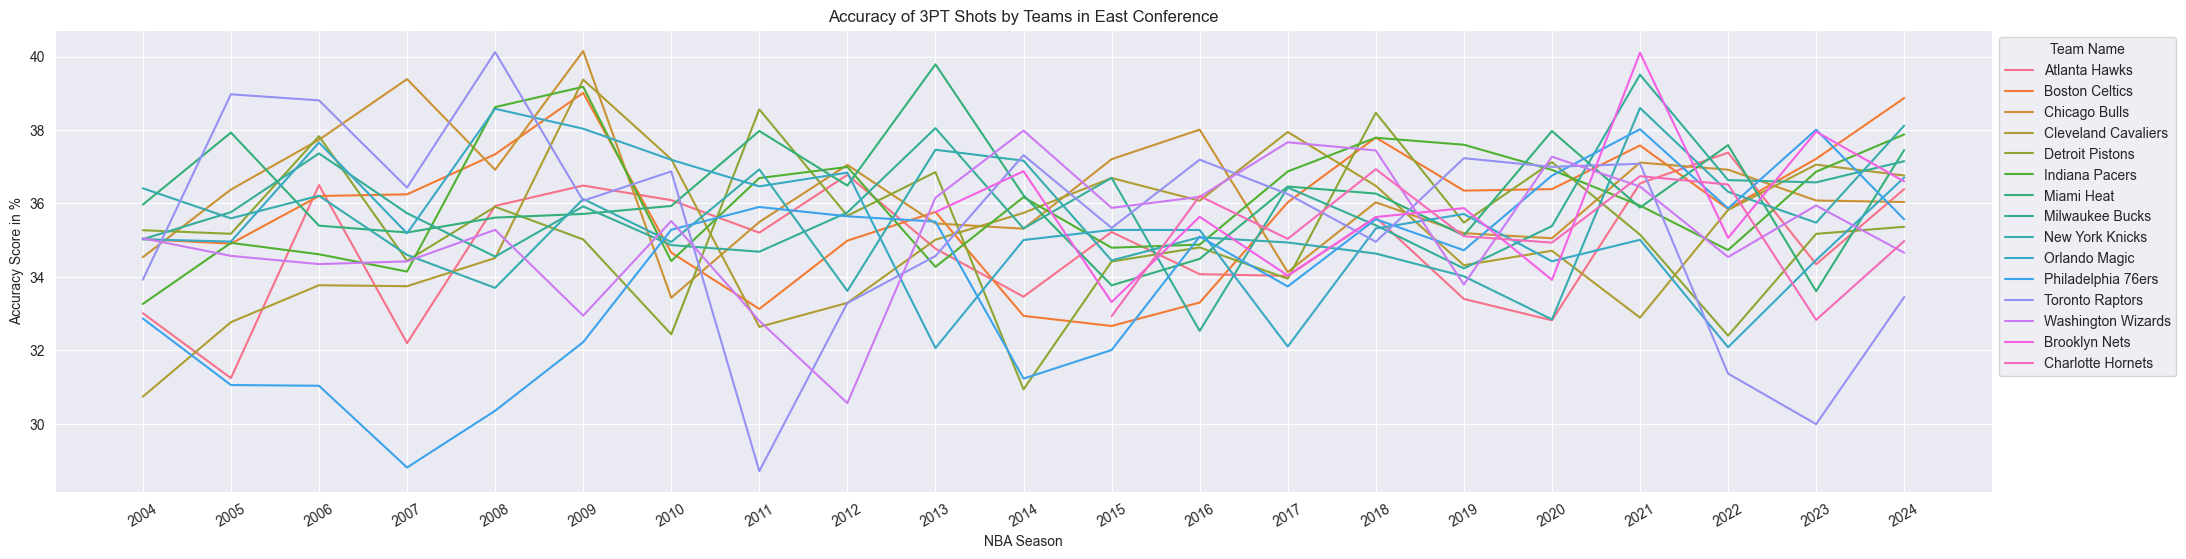

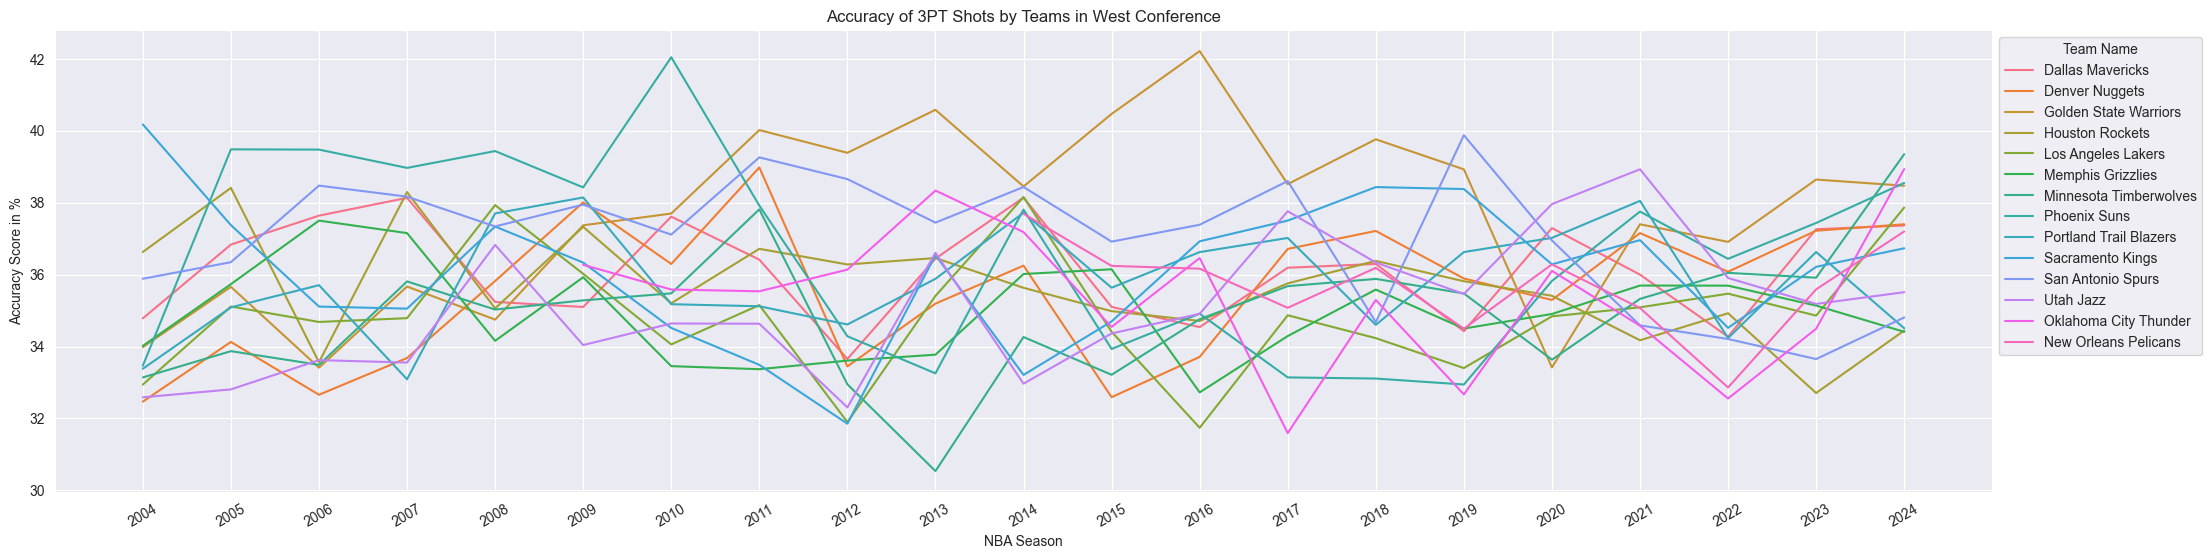

In [28]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=shot_type_df[shot_type_df["IS_3PT"] == 1], x="season", y="accuracy",
             hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference")
plt.title("Accuracy of 3PT Shots West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "East") & (shot_type_df["IS_3PT"] == 1)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 3PT Shots by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "West") & (shot_type_df["IS_3PT"] == 1)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 3PT Shots by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
plt.show()

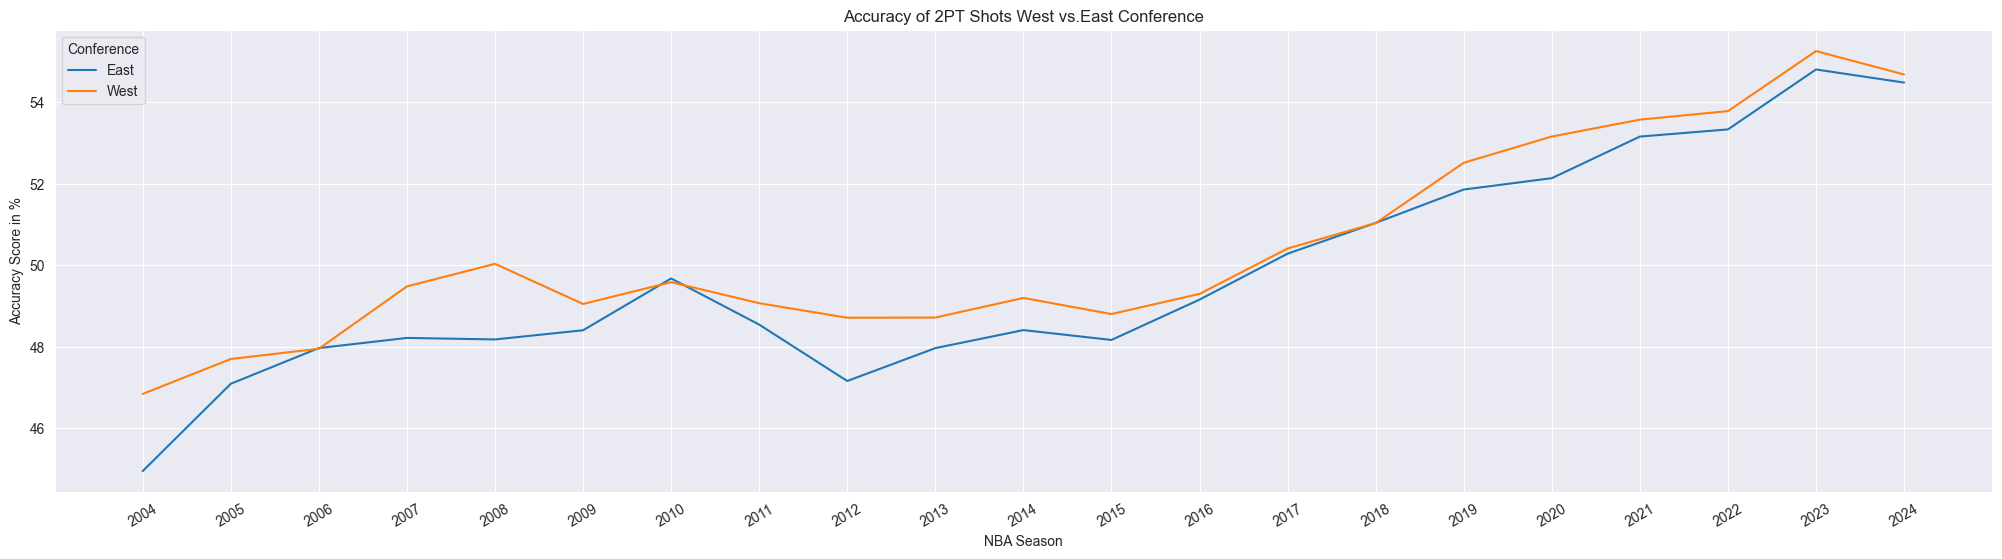

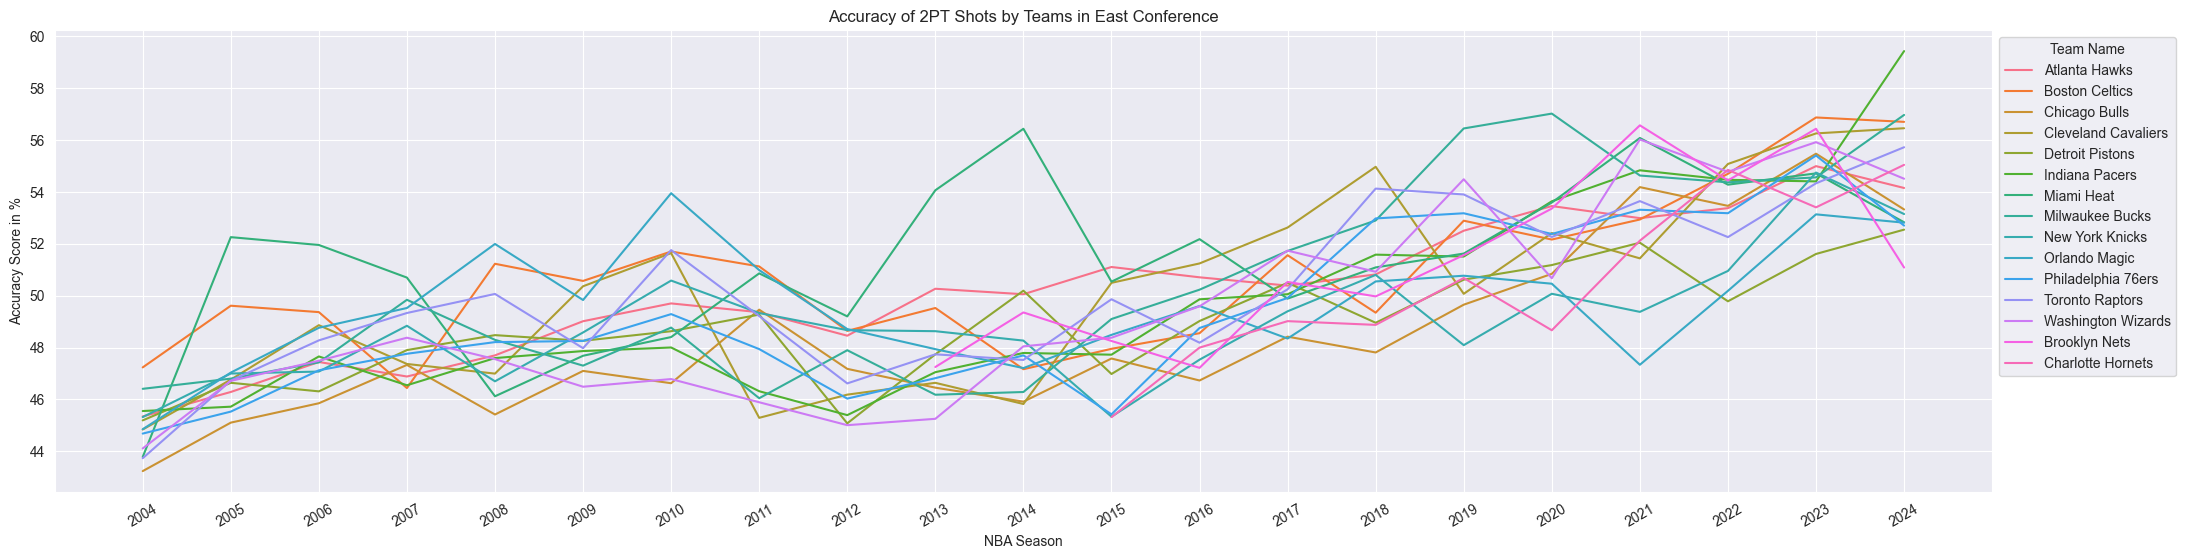

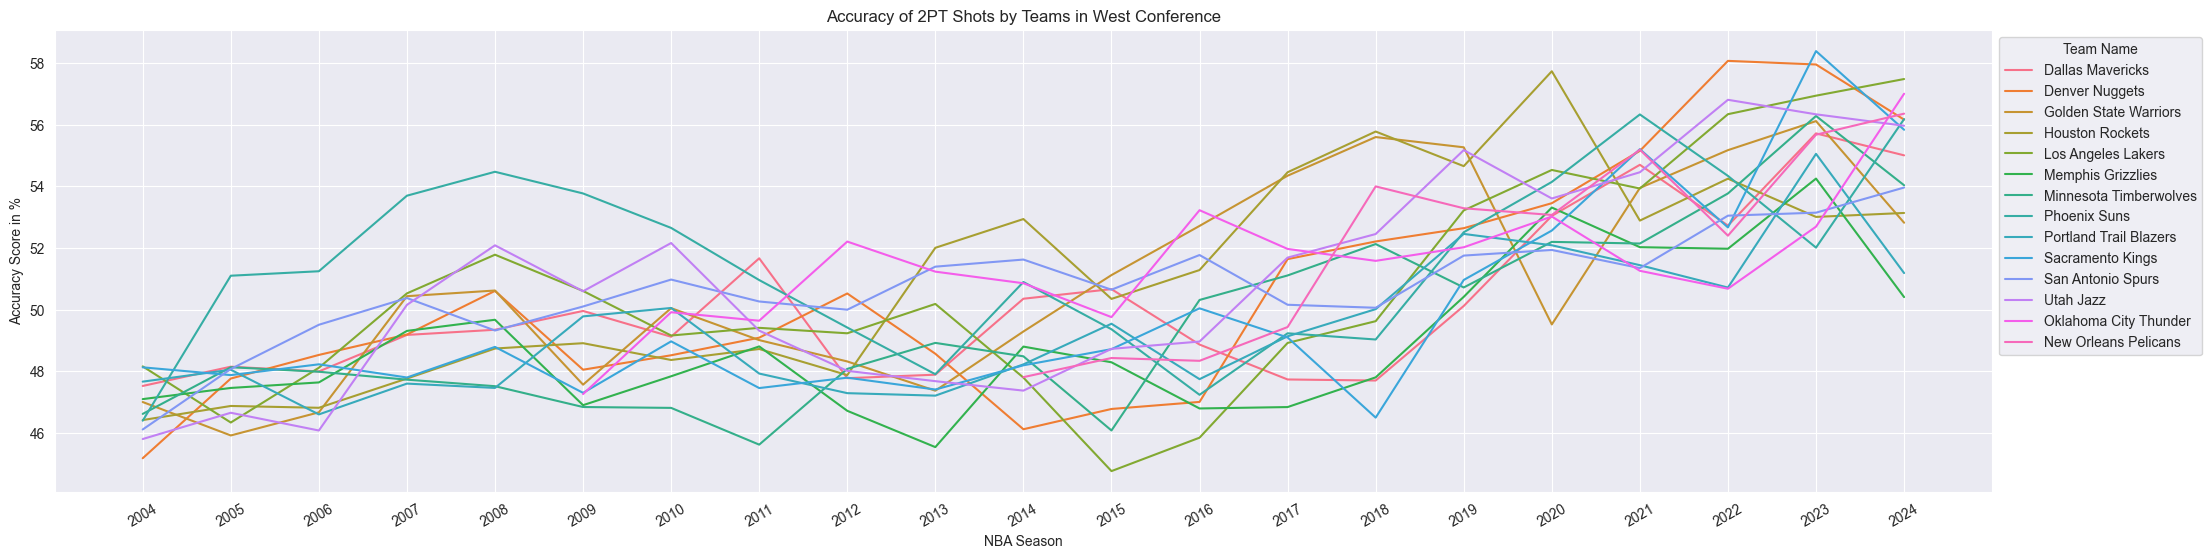

In [29]:

plt.figure(figsize=(25, 6))
sns.lineplot(data=shot_type_df[shot_type_df["IS_3PT"] == 0], x="season", y="accuracy",
             hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference")
plt.title("Accuracy of 2PT Shots West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "East") & (shot_type_df["IS_3PT"] == 0)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT Shots by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "West") & (shot_type_df["IS_3PT"] == 0)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT Shots by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
plt.show()

In [30]:
df_shots_clean.head()

SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  PLAYER_NAME  \
0      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
1      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
2      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
3      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   
4      2004  2003-04  1610612747  Los Angeles Lakers        977  Kobe Bryant   

  POSITION_GROUP POSITION   GAME_DATE   GAME_ID  ... LOC_X  LOC_Y  \
0              G       SG  04-14-2004  20301187  ...  20.0  21.35   
1              G       SG  04-14-2004  20301187  ...  13.3  24.45   
2              G       SG  04-14-2004  20301187  ...  -1.5  29.95   
3              G       SG  04-14-2004  20301187  ... -14.6  16.75   
4              G       SG  04-14-2004  20301187  ...  -0.0   5.25   

  SHOT_DISTANCE  QUARTER MINS_LEFT  SECS_LEFT TEAM_CONFERENCE  \
0            25        6         0          0            West   
1            23        6         0          9            West   
2            24        6         1         42            West   
3            18        6         2         27            West   
4             0        6         3         31            West   

  TEAM_ABBREVIATION rosterstatus is_home  
0               LAL            0       0  
1               LAL            0       0  
2               LAL            0       0  
3               LAL            0       0  
4               LAL            0       0  

[5 rows x 30 columns]

# Predictive Models
- Predict

In [31]:

#TODO: Make
query = '''
WITH PlayersShotsStats AS (
    SELECT 
        PLAYER_NAME,
        SEASON_1,
        GAME_ID,
        POSITION,
        POSITION_GROUP,
        IS_HOME,
        SUM(CASE 
            WHEN IS_3PT = 0 AND SHOT_MADE = True THEN 2
            WHEN IS_3PT = 1 AND SHOT_MADE = True THEN 3
            ELSE 0 
        END) AS PTS, -- count points scored by each player
        COUNT(SHOT_MADE) AS FGA, -- Field Goal Attempts
        SUM(CASE WHEN SHOT_MADE = True THEN 1 ELSE 0 END) AS FGM, -- Field Goals Made
        SUM(CASE WHEN IS_3PT = 1 THEN 1 ELSE 0 END) AS threePA, -- 3PT Attempts
        SUM(CASE WHEN IS_3PT = 0 THEN 1 ELSE 0 END) AS twoPA, -- 2PT Attempts
        SUM(CASE WHEN IS_3PT = 1 AND SHOT_MADE = True THEN 1 ELSE 0 END) AS threePM, -- 3PT Made
        SUM(CASE WHEN IS_3PT = 0 AND SHOT_MADE = True THEN 1 ELSE 0 END) AS twoPM, -- 2PT Made
        AVG(SHOT_DISTANCE) AS avgShotDist, -- Average Shot Distance
        PLAYER_ID
    FROM nba
    WHERE rosterstatus == 1
    GROUP BY PLAYER_NAME, SEASON_1, GAME_ID
), metrics AS (
    SELECT 
        PLAYER_NAME,
        POSITION,
        POSITION_GROUP,
        SEASON_1,
        GAME_ID,
        IS_HOME,
        PTS,
        FGA,
        FGM,
        threePA,
        threePM,
        twoPA,
        twoPM,
        avgShotDist,
        -- Field Goal Percentage (FG%)
        CASE WHEN FGA > 0 THEN CAST(FGM AS FLOAT) / FGA * 100 ELSE 0 END AS FG_Percentage,
        -- Three-Point Percentage (3P%)
        CASE WHEN threePA > 0 THEN CAST(threePM AS FLOAT) / threePA * 100 ELSE 0 END AS threePM_Percentage,
        -- Two-Point Percentage (2P%)
        CASE WHEN twoPA > 0 THEN CAST(twoPM AS FLOAT) / twoPA * 100 ELSE 0 END AS twoPM_Percentage,
        -- Effective Field Goal Percentage (eFG%)
        CASE WHEN FGA > 0 THEN (CAST(FGM AS FLOAT) + 0.5 * threePM) / FGA * 100 ELSE 0 END AS eFG_Percentage,
        -- Points Per Shot Attempt
        CASE WHEN FGA > 0 THEN CAST(PTS AS FLOAT) / FGA ELSE 0 END AS PTS_per_Shot,
        PLAYER_ID
    FROM PlayersShotsStats
)
SELECT *
FROM metrics m
WHERE PLAYER_NAME IN (
    SELECT PLAYER_NAME
    FROM PlayersShotsStats
    GROUP BY PLAYER_NAME
    HAVING COUNT(DISTINCT GAME_ID) > 5
)
ORDER BY m.SEASON_1, m.GAME_ID;
'''
# Players KPI's over 2004-2024 seasons
players_stats = pd.read_sql(query, conn)
players_stats

PLAYER_NAME POSITION POSITION_GROUP  SEASON_1   GAME_ID  IS_HOME  \
0         Udonis Haslem       PF              F      2004  20300001        0   
1         Udonis Haslem       PF              F      2004  20300004        0   
2          LeBron James       SG              G      2004  20300014        0   
3          LeBron James       SG              G      2004  20300018        0   
4         Udonis Haslem       PF              F      2004  20300020        1   
...                 ...      ...            ...       ...       ...      ...   
141410     LeBron James       PF              F      2024  22301230        1   
141411    Naji Marshall       SF              F      2024  22301230        0   
141412    Rui Hachimura       PF              F      2024  22301230        1   
141413  Trey Murphy III       SF              F      2024  22301230        0   
141414  Zion Williamson       PF              F      2024  22301230        0   

        PTS  FGA  FGM  threePA  threePM  twoPA  twoPM  avgShotDist  \
0         2    5    1        0        0      5      1     5.000000   
1         6    4    3        0        0      4      3     6.000000   
2        24   20   12        2        0     18     12    12.500000   
3        17   17    8        5        1     12      7    13.117647   
4        12   12    6        0        0     12      6     1.833333   
...     ...  ...  ...      ...      ...    ...    ...          ...   
141410   22   12    9        4        4      8      5    12.666667   
141411    3    2    1        1        1      1      0    11.500000   
141412   11    9    5        3        1      6      4    12.777778   
141413   12   13    5        7        2      6      3    15.461538   
141414   12    8    6        0        0      8      6     4.125000   

        FG_Percentage  threePM_Percentage  twoPM_Percentage  eFG_Percentage  \
0           20.000000            0.000000         20.000000       20.000000   
1           75.000000            0.000000         75.000000       75.000000   
2           60.000000            0.000000         66.666667       60.000000   
3           47.058824           20.000000         58.333333       50.000000   
4           50.000000            0.000000         50.000000       50.000000   
...               ...                 ...               ...             ...   
141410      75.000000          100.000000         62.500000       91.666667   
141411      50.000000          100.000000          0.000000       75.000000   
141412      55.555556           33.333333         66.666667       61.111111   
141413      38.461538           28.571429         50.000000       46.153846   
141414      75.000000            0.000000         75.000000       75.000000   

        PTS_per_Shot  PLAYER_ID  
0           0.400000       2617  
1           1.500000       2617  
2           1.200000       2544  
3           1.000000       2544  
4           1.000000       2617  
...              ...        ...  
141410      1.833333       2544  
141411      1.500000    1630230  
141412      1.222222    1629060  
141413      0.923077    1630530  
141414      1.500000    1629627  

[141415 rows x 20 columns]

In [32]:
players_stats = pd.merge(left=players_stats, right=df_active_players[["PLAYER_ID", "age"]], on="PLAYER_ID")
players_stats.head(2)

PLAYER_NAME POSITION POSITION_GROUP  SEASON_1   GAME_ID  IS_HOME  PTS  \
0  Udonis Haslem       PF              F      2004  20300001        0    2   
1  Udonis Haslem       PF              F      2004  20300004        0    6   

   FGA  FGM  threePA  ...  twoPA  twoPM  avgShotDist  FG_Percentage  \
0    5    1        0  ...      5      1          5.0           20.0   
1    4    3        0  ...      4      3          6.0           75.0   

   threePM_Percentage  twoPM_Percentage  eFG_Percentage  PTS_per_Shot  \
0                 0.0              20.0            20.0           0.4   
1                 0.0              75.0            75.0           1.5   

   PLAYER_ID  age  
0       2617   43  
1       2617   43  

[2 rows x 21 columns]

In [33]:
# create different rolling averages for k last games 
players_stats_model1 = players_stats
rolling_games = list(range(4, 11))
for k in rolling_games:
    print(k)
    players_stats_model1[f'FG%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'FG_Percentage'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())
    players_stats_model1[f'threePM%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'threePM_Percentage'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())
    players_stats_model1[f'twoPM%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'twoPM_Percentage'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())
    players_stats_model1[f'eFG%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'eFG_Percentage'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())
    players_stats_model1[f'PTS_per_shot_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'PTS_per_Shot'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())

4
5
6
7
8
9
10


In [34]:
# create different rolling averages for k last seasons 
rolling_seasons = list(range(2, 5))
for j in rolling_seasons:
    print(j)
    players_stats_model1[f'FG%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
        'FG_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    players_stats_model1[f'threePM%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
        'threePM_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    players_stats_model1[f'twoPM%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
        'twoPM_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    players_stats_model1[f'eFG%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
        'eFG_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    players_stats_model1[f'PTS_per_shot_rolling_{j}_seasons'] = \
        players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
            'PTS_per_Shot'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())

2
3
4


In [35]:
scaler = StandardScaler()
current_season = 2024
test_data = players_stats_model1[players_stats_model1["SEASON_1"] == current_season]
train_data = players_stats_model1[players_stats_model1["SEASON_1"] < current_season]

non_features = ["PLAYER_NAME", "PTS", "POSITION", "POSITION_GROUP", "SEASON_1", "GAME_ID", "FGM", "threePA", "twoPM",
                "avgShotDist", "FG_Percentage",
                "threePM_Percentage", "twoPM_Percentage", "eFG_Percentage", "PTS_per_Shot", "PLAYER_ID", "FGA",
                "threePM", "twoPA"
                ]

target = 'PTS'


# Using Cross Validation determine the optimal number of k and j forrolling averages over last k games and j seasons

In [36]:
from sklearn.linear_model import Ridge

n_folds = 5
k_fold_results = []
# keep track of players for which error was raised if not enough data
errors = set()
# different alpha values for Ridge Model
alphas = np.logspace(-3, 2, 50)

# have a loop for k last games
for k in rolling_games:
    # have a loop for j last seasons
    for j in rolling_seasons:
        print(f"Rolling avg for {k} last games and {j} last seasons")
        # use only k and j rolling averages
        features = [
            f'FG%_rolling_{k}_games',
            f"threePM%_rolling_{k}_games",
            f"twoPM%_rolling_{k}_games",
            f'eFG%_rolling_{k}_games',
            f'PTS_per_shot_rolling_{k}_games',
            f'FG%_rolling_{j}_seasons',
            f'twoPM%_rolling_{j}_seasons',
            f'threePM%_rolling_{j}_seasons',
            f'eFG%_rolling_{j}_seasons',
            f'PTS_per_shot_rolling_{j}_seasons',
            "age"
        ]
       
        # rolling averages using k and j for games and seasons respectively
        X = train_data[features]
        X_scaled = scaler.fit_transform(X)
        # we have PTS target variable
        y = train_data[target]
        # scale and normalize the data
        y = np.log1p(y)

        param_grid = {'alpha': alphas}
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        # find the best alpha value
        grid_search = GridSearchCV(Ridge(max_iter=5000), param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X, y)

        best_model = grid_search.best_estimator_
        best_alpha = grid_search.best_params_['alpha']
        coefficients = best_model.coef_

        # train with best alpha and evaluate using CV
        regr = Ridge(alpha=best_alpha, fit_intercept=True, max_iter=5000)
        total_r2, total_mse = [], []

        # split the data 
        for train, test in kf.split(X_scaled):
            # split the data into training and validation sets
            X_train, X_test = X_scaled[train], X_scaled[test]
            y_train, y_test = y.iloc[train], y.iloc[test]


            regr.fit(X_train, y_train)
            y_pred = regr.predict(X_test)

            f_r2 = r2_score(y_test, y_pred)
            f_mse = mean_squared_error(y_test, y_pred)

            total_r2.append(f_r2)
            total_mse.append(f_mse)


        avg_r2 = np.mean(total_r2)
        avg_mse = np.mean(total_mse)
        f_rmse = np.sqrt(avg_mse)


        k_fold_results.append({
            'k_games': k,
            'j_seasons': j,
            'R2': avg_r2,
            'MSE': avg_mse,
            "RMSE": f_rmse,
            'alpha': best_alpha,
            'coefficients': coefficients,
            "model": best_model
        })

k_fold_results_df = pd.DataFrame(k_fold_results)
k_fold_results_df_summary = k_fold_results_df.groupby(['k_games', 'j_seasons'])[
    ['R2', 'MSE', "RMSE"]].mean().reset_index()

Rolling avg for 4 last games and 2 last seasons
Rolling avg for 4 last games and 3 last seasons
Rolling avg for 4 last games and 4 last seasons
Rolling avg for 5 last games and 2 last seasons
Rolling avg for 5 last games and 3 last seasons
Rolling avg for 5 last games and 4 last seasons
Rolling avg for 6 last games and 2 last seasons
Rolling avg for 6 last games and 3 last seasons
Rolling avg for 6 last games and 4 last seasons
Rolling avg for 7 last games and 2 last seasons
Rolling avg for 7 last games and 3 last seasons
Rolling avg for 7 last games and 4 last seasons
Rolling avg for 8 last games and 2 last seasons
Rolling avg for 8 last games and 3 last seasons
Rolling avg for 8 last games and 4 last seasons
Rolling avg for 9 last games and 2 last seasons
Rolling avg for 9 last games and 3 last seasons
Rolling avg for 9 last games and 4 last seasons
Rolling avg for 10 last games and 2 last seasons
Rolling avg for 10 last games and 3 last seasons
Rolling avg for 10 last games and 4 la

In [37]:
k_fold_results_df_summary

k_games  j_seasons        R2       MSE      RMSE
0         4          2  0.310849  0.473047  0.687784
1         4          3  0.260066  0.507907  0.712676
2         4          4  0.235403  0.524839  0.724458
3         5          2  0.317724  0.468325  0.684343
4         5          3  0.266963  0.503170  0.709345
5         5          4  0.242146  0.520208  0.721255
6         6          2  0.323462  0.464389  0.681461
7         6          3  0.272609  0.499297  0.706609
8         6          4  0.247844  0.516300  0.718540
9         7          2  0.327841  0.461382  0.679251
10        7          3  0.277150  0.496180  0.704400
11        7          4  0.252350  0.513206  0.716384
12        8          2  0.331397  0.458943  0.677453
13        8          3  0.280654  0.493775  0.702691
14        8          4  0.255967  0.510724  0.714650
15        9          2  0.334942  0.456509  0.675655
16        9          3  0.284177  0.491358  0.700969
17        9          4  0.259428  0.508349  0.712986
18       10          2  0.337559  0.454713  0.674324
19       10          3  0.286871  0.489509  0.699649
20       10          4  0.262158  0.506475  0.711670

In [38]:
k_fold_results_df

k_games  j_seasons        R2       MSE      RMSE  alpha  \
0         4          2  0.310849  0.473047  0.687784    1.0   
1         4          3  0.260066  0.507907  0.712676    1.0   
2         4          4  0.235403  0.524839  0.724458    1.0   
3         5          2  0.317724  0.468325  0.684343    1.0   
4         5          3  0.266963  0.503170  0.709345    1.0   
5         5          4  0.242146  0.520208  0.721255    1.0   
6         6          2  0.323462  0.464389  0.681461    1.0   
7         6          3  0.272609  0.499297  0.706609    1.0   
8         6          4  0.247844  0.516300  0.718540    1.0   
9         7          2  0.327841  0.461382  0.679251    1.0   
10        7          3  0.277150  0.496180  0.704400    1.0   
11        7          4  0.252350  0.513206  0.716384    1.0   
12        8          2  0.331397  0.458943  0.677453    1.0   
13        8          3  0.280654  0.493775  0.702691    1.0   
14        8          4  0.255967  0.510724  0.714650    1.0   
15        9          2  0.334942  0.456509  0.675655    1.0   
16        9          3  0.284177  0.491358  0.700969    1.0   
17        9          4  0.259428  0.508349  0.712986    1.0   
18       10          2  0.337559  0.454713  0.674324    1.0   
19       10          3  0.286871  0.489509  0.699649    1.0   
20       10          4  0.262158  0.506475  0.711670    1.0   

                                                                                           coefficients  \
0   [0.03672692322897966, 0.017313324720195453, 0.006388338071851281, -0.04217078093210284, -0.00084...   
1   [0.034362007299221925, 0.016794788571029118, 0.0060053129599978205, -0.03961715959384036, -0.000...   
2   [0.030816064783392525, 0.013123142231355168, 0.002287717384891264, -0.03177394176056594, -0.0006...   
3   [0.0411802717330806, 0.0192647038433125, 0.007141253427035719, -0.0470138320219316, -0.000940276...   
4   [0.03896972621636947, 0.018878086938781, 0.0069144593983907965, -0.04485878110610084, -0.0008971...   
5   [0.038085875242620595, 0.0180895141238324, 0.006184577204062342, -0.04341335272793093, -0.000868...   
6   [0.044641313703026625, 0.02083125793180349, 0.0077216594322235335, -0.05055249286837249, -0.0010...   
7   [0.0423057905852082, 0.020470901845938538, 0.007622685044814615, -0.04841062926982907, -0.000968...   
8   [0.04103253786908366, 0.019961648602796943, 0.00723589586229054, -0.04691665309697065, -0.000938...   
9   [0.047731298107588006, 0.022062510880252576, 0.008160356852084548, -0.05366139327885925, -0.0010...   
10  [0.045558049086353906, 0.021704857956788646, 0.00804917584957415, -0.05161666789661783, -0.00103...   
11  [0.044374366989562035, 0.021255502744018214, 0.007811785710236279, -0.050368539104835, -0.001007...   
12  [0.05020817321223532, 0.023150139364921978, 0.008423261142001261, -0.05622572629175973, -0.00112...   
13  [0.04793283092281688, 0.02277572695052354, 0.008348794847967918, -0.05424873863804656, -0.001084...   
14  [0.04667548208142909, 0.02237149300539629, 0.008148061724289, -0.05304800429925139, -0.001060960...   
15  [0.0525366725016677, 0.0241811788062806, 0.008741919549986942, -0.058524588694989076, -0.0011704...   
16  [0.05019279408488341, 0.023819256348344153, 0.008691070680061167, -0.05654138701322704, -0.00113...   
17  [0.04885482959529831, 0.023451184145220336, 0.008555174131995021, -0.05539994785179069, -0.00110...   
18  [0.0544407451992798, 0.02495634509421284, 0.008986386682709102, -0.06036904697603528, -0.0012073...   
19  [0.05229139963936358, 0.024623774663822044, 0.008864510908039724, -0.05850788007830912, -0.00117...   
20  [0.051051326355620895, 0.024262789225696517, 0.00871396606392554, -0.057459456800216864, -0.0011...   

      model  
0   Ridge()  
1   Ridge()  
2   Ridge()  
3   Ridge()  
4   Ridge()  
5   Ridge()  
6   Ridge()  
7   Ridge()  
8   Ridge()  
9   Ridge()  
10  Ridge()  
11  Ridge()  
12  Ridge()  
13  Ridge()  
14  Ridge()  
15  Ridge()  
16  Ridge()  
17  Ridge(

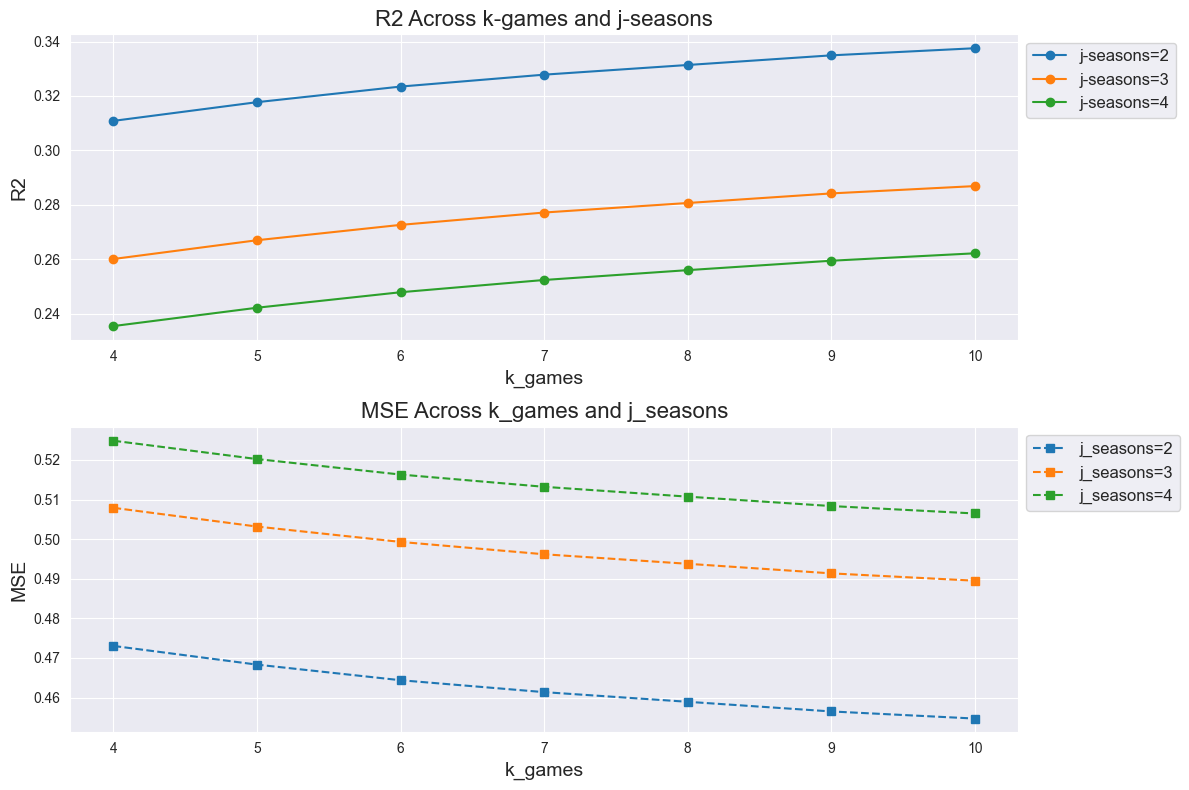

In [40]:
import matplotlib.pyplot as plt

j_values = k_fold_results_df_summary["j_seasons"].unique()

# create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# plot R2
axes[0].set_title("R2 Across k-games and j-seasons", fontsize=16)
axes[0].set_ylabel("R2", fontsize=14)
axes[0].set_xlabel("k_games", fontsize=14)
for idx, j in enumerate(j_values):
    subset = k_fold_results_df_summary[k_fold_results_df_summary["j_seasons"] == j]
    axes[0].plot(subset["k_games"], subset["R2"], marker="o", label=f"j-seasons={j}")
axes[0].legend(loc="best", fontsize=12, bbox_to_anchor=(1, 1))
axes[0].grid(True)

# plot MSE
axes[1].set_title("MSE Across k_games and j_seasons", fontsize=16)
axes[1].set_xlabel("k_games", fontsize=14)
axes[1].set_ylabel("MSE", fontsize=14)
for idx, j in enumerate(j_values):
    subset = k_fold_results_df_summary[k_fold_results_df_summary["j_seasons"] == j]
    axes[1].plot(subset["k_games"], subset["MSE"], marker="s", linestyle="--", label=f"j_seasons={j}")
axes[1].legend(loc="best", fontsize=12, bbox_to_anchor=(1, 1))
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [41]:
print(k_fold_results_df_summary["MSE"].mean())
print(k_fold_results_df_summary["R2"].mean())

0.4913620913043429
0.2841694734232993


In [ ]:
# conn.close()